# Predcition of Hospital Admission Related to Sinusitis

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sinusitis.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'sinusitis_date_'+str(i), 'sinusitis_ab_date_'+str(i), 'sinusitis_ab_type_'+str(i),
                   'incdt_sinusitis_date_'+str(i), 'admitted_sinusitis_date_'+str(i), 'sgss_gp_cov_sinusitis_date_'+str(i)]]
    
    #drop rows with no sinusitis reord
    datum = datum[datum['sinusitis_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with sinusitis_i
    datum = datum[datum['sgss_gp_cov_sinusitis_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'sinusitis_date_'+str(i): 'sinusitis_date', 'sinusitis_ab_date_'+str(i): 'sinusitis_ab_date', 
                           'sinusitis_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_sinusitis_date_'+str(i): 'incdt_sinusitis_date', 'incdt_sinusitis_type_'+str(i): 'incdt_sinusitis_type',
                           'admitted_sinusitis_date_'+str(i): 'admitted_sinusitis_date',
                           'sgss_gp_cov_sinusitis_date_'+str(i): 'sgss_gp_cov_sinusitis_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_sinusitis.csv.gz')

In [19]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [20]:
#process 20 sinusitiss and concatenate them 
data_sinusitis_1 = proc_infec_data(data,1)
data_sinusitis_2 = proc_infec_data(data,2)
data_sinusitis_3 = proc_infec_data(data,3)
data_sinusitis_4 = proc_infec_data(data,4)
data_sinusitis_5 = proc_infec_data(data,5)
data_sinusitis_6 = proc_infec_data(data,6)
data_sinusitis_7 = proc_infec_data(data,7)
data_sinusitis_8 = proc_infec_data(data,8)
data_sinusitis_9 = proc_infec_data(data,9)
data_sinusitis_10 = proc_infec_data(data,10)
data_sinusitis_11 = proc_infec_data(data,11)
data_sinusitis_12 = proc_infec_data(data,12)
data_sinusitis_13 = proc_infec_data(data,13)
data_sinusitis_14 = proc_infec_data(data,14)
data_sinusitis_15 = proc_infec_data(data,15)
data_sinusitis_16 = proc_infec_data(data,16)
data_sinusitis_17 = proc_infec_data(data,17)
data_sinusitis_18 = proc_infec_data(data,18)
data_sinusitis_19 = proc_infec_data(data,19)
data_sinusitis_20 = proc_infec_data(data,20)

data_sinusitis = pd.concat([data_sinusitis_1, data_sinusitis_2, data_sinusitis_3, data_sinusitis_4, data_sinusitis_5, data_sinusitis_6, data_sinusitis_7, data_sinusitis_8, data_sinusitis_9, data_sinusitis_10, data_sinusitis_11, data_sinusitis_12, data_sinusitis_13, data_sinusitis_14, data_sinusitis_15, data_sinusitis_16, data_sinusitis_17, data_sinusitis_18, data_sinusitis_19, data_sinusitis_20])
data_sinusitis.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [21]:
##add variable season
#convert data types
data_sinusitis['sinusitis_date'] = data_sinusitis['sinusitis_date'].astype('datetime64[ns]')
data_sinusitis['admitted_sinusitis_date'] = data_sinusitis['admitted_sinusitis_date'].astype('datetime64[ns]')
data_sinusitis.died_date = data_sinusitis.died_date.astype('datetime64[ns]')
data_sinusitis.deregistered_date = data_sinusitis.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_sinusitis['date'] = data_sinusitis['sinusitis_date'] 
data_sinusitis['date'] = data_sinusitis['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_sinusitis with today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_1_month_date_y_m]
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of sinusitis records
data_sinusitis['season'] = np.nan
data_sinusitis['date_month'] = pd.DatetimeIndex(data_sinusitis['date']).month

conditions = [
    (data_sinusitis['date_month'] >= 3) & (data_sinusitis['date_month'] <= 5),
    (data_sinusitis['date_month'] >= 6) & (data_sinusitis['date_month'] <= 8),
    (data_sinusitis['date_month'] >= 9) & (data_sinusitis['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_sinusitis['season'] = np.select(conditions, choices, default='winter')

In [22]:
#add variable time period
data_sinusitis.loc[(data_sinusitis['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_sinusitis.loc[((data_sinusitis['date'] >= '2020-01') & (data_sinusitis['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_sinusitis.loc[(data_sinusitis['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [23]:
#scenario 1
#not hosped (nothing happened)
data_sinusitis.loc[data_sinusitis['admitted_sinusitis_date'].isnull(), 'event_sinusitis_admitted'] = 0

In [24]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] >= 0) & (data_sinusitis['delta_sinusitis_admitted'] <= 30)), 'event_sinusitis_admitted'] = 1

#scenario 2
#drop whoever was admitted before sinusitis consultation, i.e. negative value for delta_sinusitis_admitted
data_sinusitis = data_sinusitis[~(data_sinusitis['delta_sinusitis_admitted'] < 0)]

In [25]:
#scenario 3
#censor died patients
data_sinusitis['delta_admitted_died'] = (data_sinusitis['died_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_died'] >= 0) & (data_sinusitis['delta_admitted_died'] <= 30)), 'event_sinusitis_admitted'] = 0

#scenario 3
#censor deregistered patients
data_sinusitis['delta_admitted_deregistered'] = (data_sinusitis['deregistered_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_deregistered'] > 0) & (data_sinusitis['delta_admitted_deregistered'] <= 30)), 'event_sinusitis_admitted'] = 0

#agg scenario 3s
data_sinusitis['delta_admitted_died_deregistered'] = data_sinusitis['delta_admitted_deregistered'].combine_first(data_sinusitis['delta_admitted_died'])
data_sinusitis.loc[data_sinusitis['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [26]:
#scenario 1
#any other patients (nothing happened)
data_sinusitis['event_sinusitis_admitted'] = data_sinusitis['event_sinusitis_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['delta_sinusitis_admitted'].combine_first(data_sinusitis['delta_admitted_died_deregistered'])
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['duration_sinusitis_admitted'].replace(np.NaN, 30)
data_sinusitis.loc[(data_sinusitis['duration_sinusitis_admitted'] > 30), 'duration_sinusitis_admitted'] = 30

#give value 1 to event_sinusitis_admitted if duration_sinusitis_admitted is greater or equal to 0 and less than 30
data_sinusitis.loc[((data_sinusitis['duration_sinusitis_admitted'] >= 0) & (data_sinusitis['duration_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

#drop any rows with value 0 in duration column
data_sinusitis = data_sinusitis[~(data_sinusitis['duration_sinusitis_admitted'] == 0)]

In [27]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] > 0) & (data_sinusitis['delta_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [28]:
#drop anybody with age less than 18 or 0!
data_sinusitis = data_sinusitis[~(data_sinusitis['age'] < 18)] 
data_sinusitis['age'][data_sinusitis['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '0-4']
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_sinusitis['bmi'][data_sinusitis['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_sinusitis['bmi'] = data_sinusitis['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_sinusitis['antibacterial_brit'][data_sinusitis['antibacterial_brit'] < 0] = np.nan

In [29]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"smoking_status": dict_smoking})

In [30]:
#drop rows with missing region
if ('region' in data_sinusitis.columns) and (data_sinusitis['region'].isnull().sum() > 0):
   data_sinusitis = data_sinusitis[data_sinusitis['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_sinusitis.columns) and (data_sinusitis['antibacterial_brit'].isnull().sum() > 0):
    data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_sinusitis.columns) and (data_sinusitis['ethnicity'].isnull().sum() > 0):
    data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_sinusitis.columns) and (data_sinusitis['smoking_status'].isnull().sum() > 0):
    data_sinusitis['smoking_status'] = data_sinusitis['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_sinusitis.columns) and (data_sinusitis['imd'].isnull().sum() > 0):
    data_sinusitis['imd'] = data_sinusitis['imd'].fillna(0)

In [31]:
#missing values of bmi assign 5 and 0; categorise bmi
data_sinusitis['bmi_cat'] = 5

for idx, x in enumerate(data_sinusitis['bmi_cat']):
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 30:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 25) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 30):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 18.5) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 25):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 18.5:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_sinusitis.columns) and (data_sinusitis['bmi_cat'].isnull().sum() > 0):
    data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].fillna(0)

In [32]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_sinusitis.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_sinusitis['ab_type_cat'] = np.where(data_sinusitis['ab_type'].isin(ab_series[mask].index),'other',data_sinusitis['ab_type'])
#assign no to non ab users
data_sinusitis.loc[data_sinusitis['sinusitis_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_sinusitis['ab_type_cat'] = data_sinusitis['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [33]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"ethnicity": dict_ethnicity})
data_sinusitis = data_sinusitis.replace({"smoking_status": dict_smoking})
data_sinusitis = data_sinusitis.replace({"imd": dict_imd})
data_sinusitis = data_sinusitis.replace({"bmi_cat": dict_bmi})
data_sinusitis = data_sinusitis.replace({"flu_vaccine": dict_flu})
data_sinusitis = data_sinusitis.replace({"region": dict_region})
data_sinusitis = data_sinusitis.replace({"age_cat": dict_age})
data_sinusitis = data_sinusitis.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [34]:
#categorise CCI
data_sinusitis['CCI_cat'] = pd.cut(data_sinusitis['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_sinusitis['antibacterial_brit'].clip(0, data_sinusitis['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

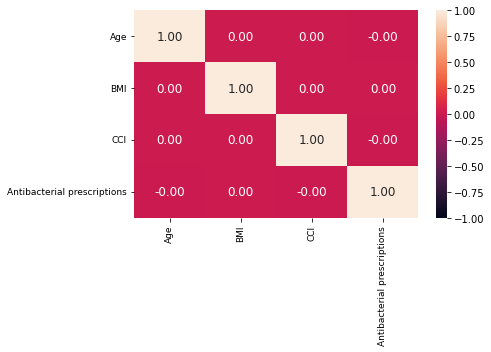

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_sinusitis[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/corr_sinusitis.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [36]:
data_sinusitis = data_sinusitis[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'sinusitis_ab_date', 'ab_type_cat', 'incdt_sinusitis_date', 'date', 'period',
                                   'event_sinusitis_admitted', 'duration_sinusitis_admitted'
                                    ]]

In [37]:
#incident and prevalent infection 
data_sinusitis_incdt = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 0]
data_sinusitis_prevl = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 1]
#switch variable sinusitis_ab_date into a binary variable
data_sinusitis_incdt[['sinusitis_ab_date']] = data_sinusitis_incdt[['sinusitis_ab_date']].where(data_sinusitis_incdt[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)
data_sinusitis_prevl[['sinusitis_ab_date']] = data_sinusitis_prevl[['sinusitis_ab_date']].where(data_sinusitis_prevl[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_sinusitis_incdt_males = data_sinusitis_incdt[data_sinusitis_incdt['sex'] == 'male']
data_sinusitis_incdt_females = data_sinusitis_incdt[data_sinusitis_incdt['sex'] == 'female']
data_sinusitis_prevl_males = data_sinusitis_prevl[data_sinusitis_prevl['sex'] == 'male']
data_sinusitis_prevl_females = data_sinusitis_prevl[data_sinusitis_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_sinusitis_incdt_15_24 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '15_24']
data_sinusitis_incdt_25_34 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '25_34']
data_sinusitis_incdt_35_44 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '35_44']
data_sinusitis_incdt_45_54 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '45_54']
data_sinusitis_incdt_55_64 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '55_64']
data_sinusitis_incdt_65_74 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '65_74']
data_sinusitis_incdt_75_more = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '75_more']
data_sinusitis_prevl_15_24 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '15_24']
data_sinusitis_prevl_25_34 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '25_34']
data_sinusitis_prevl_35_44 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '35_44']
data_sinusitis_prevl_45_54 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '45_54']
data_sinusitis_prevl_55_64 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '55_64']
data_sinusitis_prevl_65_74 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '65_74']
data_sinusitis_prevl_75_more = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_sinusitis_incdt_prepandemic = data_sinusitis_incdt[data_sinusitis_incdt['date'] <= '2019-12']
data_sinusitis_incdt_during_pandemic = data_sinusitis_incdt[(data_sinusitis_incdt['date'] >= '2020-03') & (data_sinusitis_incdt['date']<= '2021-03')]
data_sinusitis_incdt_post_2nd_lockdown = data_sinusitis_incdt[data_sinusitis_incdt['date'] <= '2021-04']
data_sinusitis_prevl_prepandemic = data_sinusitis_prevl[data_sinusitis_prevl['date'] <= '2019-12']
data_sinusitis_prevl_during_pandemic = data_sinusitis_prevl[(data_sinusitis_prevl['date'] >= '2020-03') & (data_sinusitis_prevl['date']<= '2021-03')]
data_sinusitis_prevl_post_2nd_lockdown = data_sinusitis_prevl[data_sinusitis_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt = data_sinusitis[data_sinusitis['sinusitis_ab_date'].isnull()]
data_sinusitis_no_abs_incdt = data_sinusitis_no_abs_incdt[data_sinusitis_no_abs_incdt['incdt_sinusitis_date'] == 0]

# with antibiotics and incident hospital admission
data_sinusitis_abs_incdt = data_sinusitis[data_sinusitis['sinusitis_ab_date'].notnull()]
data_sinusitis_abs_incdt = data_sinusitis_abs_incdt[data_sinusitis_abs_incdt['incdt_sinusitis_date'] == 0]

# no antibiotics and prevalent hospital admission
data_sinusitis_no_abs_prevl = data_sinusitis[data_sinusitis['sinusitis_ab_date'].isnull()]
data_sinusitis_no_abs_prevl = data_sinusitis_no_abs_prevl[data_sinusitis_no_abs_prevl['incdt_sinusitis_date'] == 1]

# with antibiotics and prevalent hospital admission
data_sinusitis_abs_prevl = data_sinusitis[data_sinusitis['sinusitis_ab_date'].notnull()]
data_sinusitis_abs_prevl = data_sinusitis_abs_prevl[data_sinusitis_abs_prevl['incdt_sinusitis_date'] == 1]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_sinusitis
# save data
data_sinusitis.to_csv('../output/hospitalisation_prediction_sinusitis/data_sinusitis.csv')

Stored 'data_sinusitis' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident sinusitis with no antibiotics

<lifelines.CoxPHFitter: fitted with 112592 total observations, 111794 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 112592
number of events observed = 798
   partial log-likelihood = -9263.49
         time fit was run = 2023-02-02 11:23:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.10            -0.23             0.18                 0.79                 1.19
CCI_cat[T.medium]               -0.02       0.98       0.12            -0.25             0.21                 0.78                 1.23
CCI_cat[T.high]                 -0.07       0.94       0.14            -0.34             0.21                 0.71                 1.23
CCI_cat[T.very_high]             0.01       1.01       0.12            -0.23             0.25                 0.80                 1.28
age_cat[T.25_34]                 0.09       1.09       0.13            -0.17             0.34                 0.85                 1.40
age_cat[T.35_44]                -0.08       0.92       0.13            -0.35             0.18                 0.71                 1.19
age_cat[T.45_54]                 0.08       1.08       0.13            -0.17             0.33                 0.84                 1.39
age_cat[T.55_64]                -0.11       0.90       0.13            -0.37             0.16                 0.69                 1.17
age_cat[T.65_74]                -0.06       0.95       0.13            -0.32             0.21                 0.73                 1.23
age_cat[T.75_more]              -0.07       0.94       0.13            -0.33             0.20                 0.72                 1.22
antibacterial_brit              -0.05       0.95       0.03            -0.10             0.00                 0.91                 1.00
bmi_cat[T.obese]                 0.05       1.05       0.14            -0.22             0.32                 0.81                 1.37
bmi_cat[T.overweight]           -0.07       0.93       0.17            -0.40             0.26                 0.67                 1.30
bmi_cat[T.underweight]           0.11       1.12       0.23            -0.34             0.56                 0.71                 1.75
bmi_cat[T.unknown]               0.11       1.11       0.14            -0.17             0.39                 0.84                 1.48
ethnicity[T.unknown]            -0.08       0.92       0.11            -0.31             0.14                 0.74                 1.15
ethnicity[T.white]              -0.12       0.88       0.10            -0.32             0.07                 0.73                 1.07
flu_vaccine[T.yes]               0.05       1.05       0.12            -0.18             0.27                 0.83                 1.31
imd[T.medium]                   -0.11       0.90       0.11            -0.33             0.12                 0.72                 1.12
imd[T.unaffluent]               -0.14       0.87       0.12            -0.37             0.09                 0.69                 1.09
imd[T.unknown]                  -0.26       0.77       0.19            -0.64             0.11                 0.53                 1.12
imd[T.very_affluent]            -0.01       0.99       0.11            -0.23             0.21                 0.79                 1.23
imd[T.very_unaffluent]          -0.03       0.97       0.11            -0.25             0.19                 0.78                 1.21
region[T.east_midlands]          0.12       1.13       0.15            -0.18             0.42                 0.84                 1.52
region[T.london]                -0.00       1.00       

11984


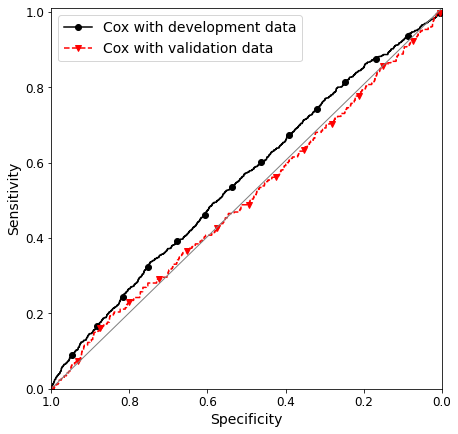

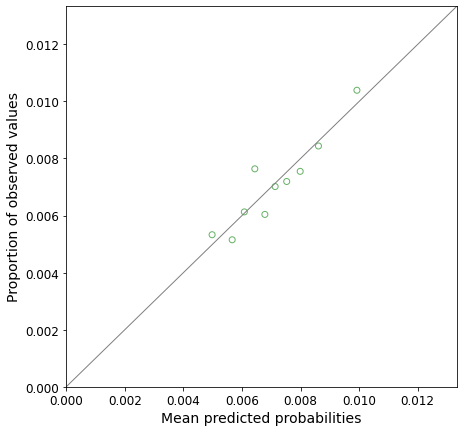

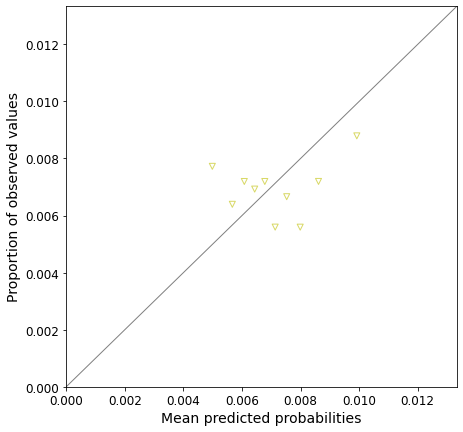

In [39]:
#data prep
data, data_sinusitis_no_abs_incdt_enc = cox_data_prep(data_sinusitis_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)

try:
    #build cox model 
    cph_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test = cox_model_build('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_sinusitis_no_abs_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_no_abs_incdt.csv', data_sinusitis_no_abs_incdt_enc, data_sinusitis_no_abs_incdt, 'sum_betas_cph_sinusitis_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_sinusitis_no_abs_incdt, 'event_sinusitis_admitted', data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_train, 'event_sinusitis_admitted', data_sinusitis_no_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_no_abs_incdt_train.jpg', 'calibration_cph_sinusitis_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_no_abs_incdt, 'sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident sinusitis with antibiotics

<lifelines.CoxPHFitter: fitted with 12361 total observations, 12269 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 12361
number of events observed = 92
   partial log-likelihood = -848.80
         time fit was run = 2023-02-02 11:24:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.33       0.34            -0.37             0.95                 0.69                 2.58
CCI_cat[T.medium]                0.28       1.33       0.37            -0.43             1.00                 0.65                 2.72
CCI_cat[T.high]                  0.53       1.70       0.40            -0.26             1.32                 0.77                 3.73
CCI_cat[T.very_high]             0.04       1.04       0.40            -0.75             0.82                 0.47                 2.28
age_cat[T.25_34]                -0.15       0.86       0.43            -1.00             0.69                 0.37                 1.99
age_cat[T.35_44]                -0.23       0.79       0.43            -1.07             0.61                 0.34                 1.84
age_cat[T.45_54]                 0.60       1.82       0.36            -0.11             1.31                 0.89                 3.70
age_cat[T.55_64]                 0.18       1.19       0.39            -0.59             0.95                 0.55                 2.59
age_cat[T.65_74]                -0.06       0.94       0.42            -0.88             0.76                 0.41                 2.13
age_cat[T.75_more]               0.20       1.23       0.39            -0.57             0.98                 0.57                 2.66
antibacterial_brit              -0.04       0.96       0.07            -0.19             0.10                 0.83                 1.11
bmi_cat[T.obese]                 0.32       1.38       0.43            -0.53             1.17                 0.59                 3.22
bmi_cat[T.overweight]           -0.34       0.71       0.58            -1.47             0.79                 0.23                 2.21
bmi_cat[T.underweight]           0.22       1.25       0.71            -1.17             1.61                 0.31                 5.00
bmi_cat[T.unknown]               0.33       1.39       0.45            -0.56             1.22                 0.57                 3.38
ethnicity[T.unknown]             0.14       1.15       0.37            -0.58             0.87                 0.56                 2.39
ethnicity[T.white]               0.26       1.30       0.33            -0.38             0.91                 0.68                 2.48
flu_vaccine[T.yes]               0.21       1.23       0.32            -0.42             0.84                 0.66                 2.32
imd[T.medium]                   -0.30       0.74       0.35            -0.98             0.38                 0.38                 1.46
imd[T.unaffluent]                0.02       1.02       0.32            -0.61             0.65                 0.54                 1.92
imd[T.unknown]                  -0.08       0.92       0.50            -1.07             0.91                 0.34                 2.47
imd[T.very_affluent]            -0.51       0.60       0.37            -1.23             0.22                 0.29                 1.24
imd[T.very_unaffluent]           0.08       1.09       0.32            -0.54             0.71                 0.58                 2.03
region[T.east_midlands]         -0.80       0.45       0.54            -1.86             0.26                 0.16                 1.30
region[T.london]                -0.01       0.99       0.37 

11963


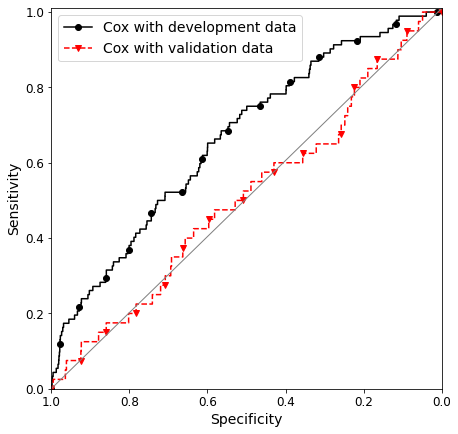

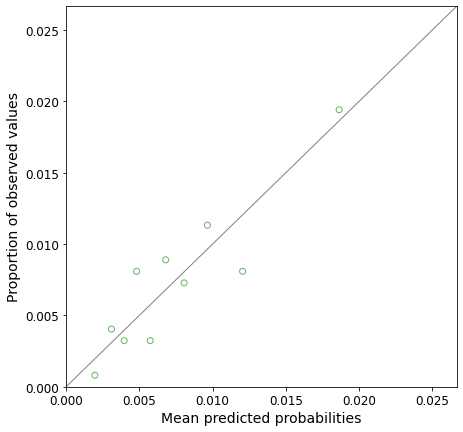

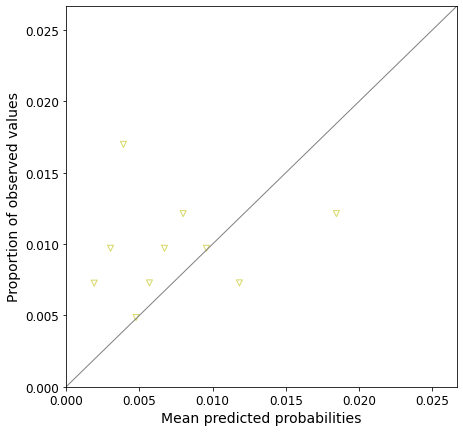

In [40]:
#data prep
data, data_sinusitis_abs_incdt_enc = cox_data_prep(data_sinusitis_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)

try:
    #build cox model 
    cph_sinusitis_abs_incdt, data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test = cox_model_build('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_sinusitis_abs_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_abs_incdt.csv', data_sinusitis_abs_incdt_enc, data_sinusitis_abs_incdt, 'sum_betas_cph_sinusitis_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_sinusitis_abs_incdt, 'event_sinusitis_admitted', data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_sinusitis_abs_incdt, data_sinusitis_abs_incdt_train, 'event_sinusitis_admitted', data_sinusitis_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_abs_incdt_train.jpg', 'calibration_cph_sinusitis_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_abs_incdt, 'sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent sinusitis with no antibiotics

<lifelines.CoxPHFitter: fitted with 12570 total observations, 12467 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 12570
number of events observed = 103
   partial log-likelihood = -952.87
         time fit was run = 2023-02-02 11:24:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.41       0.67       0.29            -0.97             0.16                 0.38                 1.17
CCI_cat[T.medium]               -0.13       0.88       0.31            -0.73             0.47                 0.48                 1.60
CCI_cat[T.high]                 -0.10       0.90       0.37            -0.83             0.63                 0.43                 1.88
CCI_cat[T.very_high]            -0.07       0.94       0.31            -0.68             0.55                 0.51                 1.73
age_cat[T.25_34]                 0.87       2.40       0.40             0.09             1.66                 1.10                 5.24
age_cat[T.35_44]                 0.21       1.23       0.45            -0.68             1.09                 0.51                 2.97
age_cat[T.45_54]                 0.32       1.37       0.43            -0.53             1.17                 0.59                 3.22
age_cat[T.55_64]                 0.52       1.68       0.42            -0.31             1.35                 0.74                 3.85
age_cat[T.65_74]                 0.79       2.20       0.41            -0.00             1.58                 1.00                 4.88
age_cat[T.75_more]               0.50       1.65       0.42            -0.33             1.33                 0.72                 3.77
antibacterial_brit               0.13       1.13       0.07            -0.01             0.26                 0.99                 1.29
bmi_cat[T.obese]                -0.33       0.72       0.33            -0.98             0.33                 0.38                 1.39
bmi_cat[T.overweight]           -0.44       0.64       0.44            -1.30             0.42                 0.27                 1.52
bmi_cat[T.underweight]          -0.85       0.43       0.77            -2.36             0.66                 0.09                 1.93
bmi_cat[T.unknown]              -0.21       0.81       0.36            -0.91             0.49                 0.40                 1.64
ethnicity[T.unknown]             0.12       1.13       0.30            -0.47             0.71                 0.62                 2.04
ethnicity[T.white]              -0.18       0.84       0.28            -0.72             0.37                 0.49                 1.45
flu_vaccine[T.yes]               0.17       1.18       0.31            -0.44             0.77                 0.65                 2.16
imd[T.medium]                    0.19       1.21       0.30            -0.41             0.78                 0.67                 2.19
imd[T.unaffluent]               -0.16       0.85       0.33            -0.81             0.49                 0.45                 1.63
imd[T.unknown]                   0.18       1.20       0.47            -0.73             1.10                 0.48                 3.00
imd[T.very_affluent]            -0.20       0.82       0.34            -0.86             0.45                 0.42                 1.58
imd[T.very_unaffluent]          -0.02       0.98       0.32            -0.64             0.60                 0.53                 1.82
region[T.east_midlands]         -0.62       0.54       0.56            -1.71             0.48                 0.18                 1.61
region[T.london]                 0.41       1.51       0.38

11971


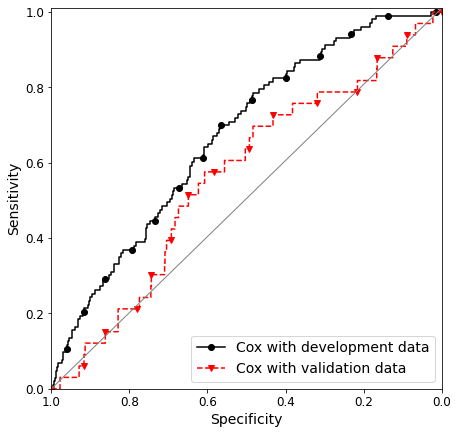

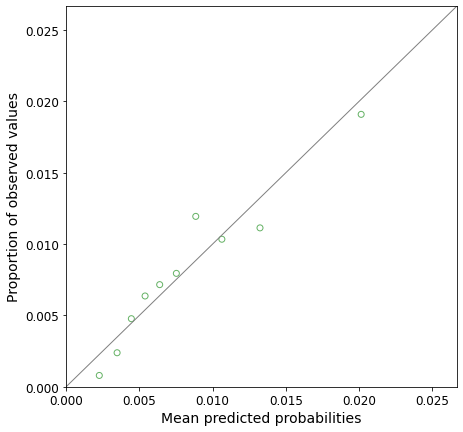

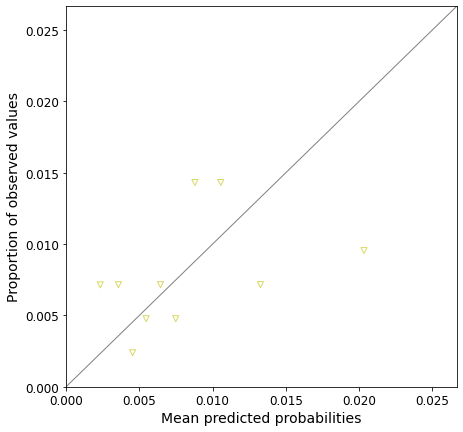

In [41]:
#data prep
data, data_sinusitis_no_abs_prevl_enc = cox_data_prep(data_sinusitis_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)

try:
    #build cox model 
    cph_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test = cox_model_build('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_sinusitis_no_abs_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_no_abs_prevl.csv', data_sinusitis_no_abs_prevl_enc, data_sinusitis_no_abs_prevl, 'sum_betas_cph_sinusitis_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_sinusitis_no_abs_prevl, 'event_sinusitis_admitted', data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_train, 'event_sinusitis_admitted', data_sinusitis_no_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_no_abs_prevl_train.jpg', 'calibration_cph_sinusitis_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_no_abs_prevl, 'sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent sinusitis with antibiotics

<lifelines.CoxPHFitter: fitted with 1353 total observations, 1348 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1353
number of events observed = 5
   partial log-likelihood = -13.76
         time fit was run = 2023-02-02 11:24:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   5.13     168.47       5.52            -5.69            15.94                 0.00             8.39e+06
CCI_cat[T.medium]                8.75    6337.12       6.54            -4.06            21.56                 0.02             2.32e+09
CCI_cat[T.high]                  3.05      21.20       9.48           -15.52            21.63                 0.00             2.47e+09
CCI_cat[T.very_high]             7.37    1593.52       6.82            -5.99            20.74                 0.00             1.02e+09
age_cat[T.25_34]                 8.51    4967.13       7.94            -7.05            24.07                 0.00             2.84e+10
age_cat[T.35_44]                 1.07       2.93      11.29           -21.05            23.20                 0.00             1.19e+10
age_cat[T.45_54]                 8.61    5510.36       8.12            -7.31            24.54                 0.00             4.54e+10
age_cat[T.55_64]                 7.37    1592.37       7.81            -7.93            22.68                 0.00             7.06e+09
age_cat[T.65_74]                 7.23    1379.28       7.79            -8.04            22.50                 0.00             5.89e+09
age_cat[T.75_more]              -1.14       0.32      10.16           -21.06            18.77                 0.00             1.42e+08
antibacterial_brit               0.13       1.14       0.53            -0.90             1.17                 0.41                 3.22
bmi_cat[T.obese]                -4.33       0.01       2.97           -10.15             1.49                 0.00                 4.42
bmi_cat[T.overweight]            1.33       3.80       2.45            -3.46             6.13                 0.03               461.17
bmi_cat[T.underweight]          -2.51       0.08      28.93           -59.22            54.19                 0.00             3.44e+23
bmi_cat[T.unknown]               1.37       3.92       2.37            -3.28             6.01                 0.04               408.41
ethnicity[T.unknown]             3.27      26.41       4.80            -6.13            12.68                 0.00             3.21e+05
ethnicity[T.white]               1.84       6.28       3.13            -4.30             7.98                 0.01              2917.18
flu_vaccine[T.yes]               1.67       5.31       2.61            -3.44             6.78                 0.03               882.29
imd[T.medium]                   -1.41       0.25       6.07           -13.31            10.49                 0.00             36089.06
imd[T.unaffluent]                0.83       2.30       1.97            -3.04             4.70                 0.05               110.37
imd[T.unknown]                  -3.19       0.04      11.75           -26.23            19.84                 0.00             4.13e+08
imd[T.very_affluent]             1.11       3.03       1.96            -2.73             4.94                 0.07               139.83
imd[T.very_unaffluent]           5.05     156.80       3.80            -2.39            12.50                 0.09             2.67e+05
region[T.east_midlands]        -10.87       0.00      11.52           -33.44            11.70                 0.00             1.21e+05
region[T.london]               -11.14       0.00       7.98      

12166


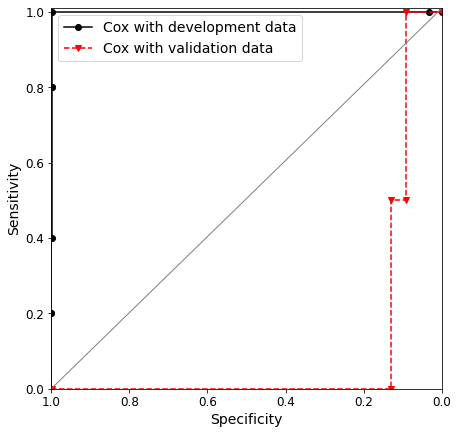

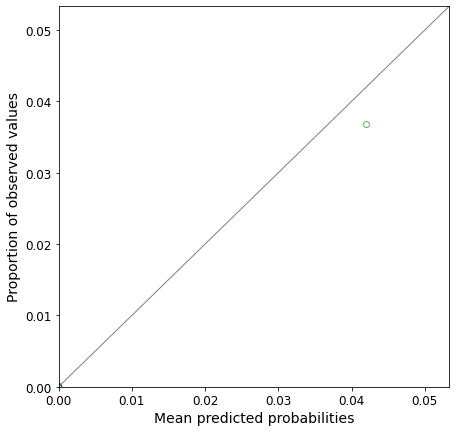

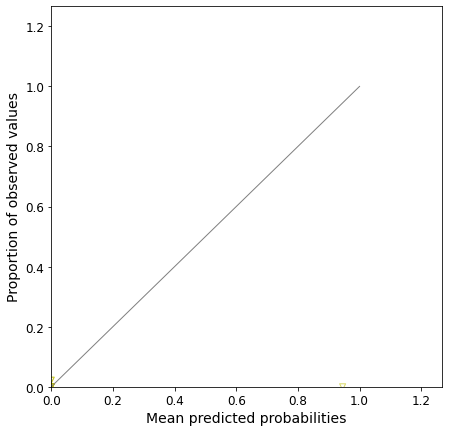

In [42]:
#data prep
data, data_sinusitis_abs_prevl_enc = cox_data_prep(data_sinusitis_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)

try:
    #build cox model 
    cph_sinusitis_abs_prevl, data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test = cox_model_build('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_sinusitis_abs_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_abs_prevl.csv', data_sinusitis_abs_prevl_enc, data_sinusitis_abs_prevl, 'sum_betas_cph_sinusitis_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_sinusitis_abs_prevl, 'event_sinusitis_admitted', data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_sinusitis_abs_prevl, data_sinusitis_abs_prevl_train, 'event_sinusitis_admitted', data_sinusitis_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_abs_prevl_train.jpg', 'calibration_cph_sinusitis_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_abs_prevl, 'sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident sinusitis

In [43]:
#data prep
data, data_sinusitis_incdt_enc = cox_data_prep(data_sinusitis_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary tables from preped data
make_summary_table('sinusitis', 'incdt', data_sinusitis_incdt_enc)
make_summary_table_hosped('sinusitis', 'incdt', data_sinusitis_incdt)

try:
    cph_sinusitis_incdt, data_sinusitis_incdt_train, data_sinusitis_incdt_test = cox_model_abs_build('sinusitis', 'incdt', data_sinusitis_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt, 'sinusitis', 'incdt', data_sinusitis_incdt_train, data_sinusitis_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 124953 total observations, 124047 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 124953
number of events observed = 906
   partial log-likelihood = -10607.15
         time fit was run = 2023-02-02 11:24:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.07       0.93       0.10            -0.26             0.12                 0.77                 1.13
CCI_cat[T.medium]               -0.13       0.88       0.11            -0.35             0.08                 0.71                 1.09
CCI_cat[T.high]                 -0.11       0.89       0.13            -0.37             0.14                 0.69                 1.15
CCI_cat[T.very_high]             0.02       1.02       0.11            -0.20             0.24                 0.82                 1.27
age_cat[T.25_34]                 0.07       1.07       0.12            -0.17             0.31                 0.84                 1.37
age_cat[T.35_44]                -0.01       0.99       0.12            -0.25             0.24                 0.78                 1.27
age_cat[T.45_54]                 0.06       1.07       0.12            -0.18             0.30                 0.84                 1.36
age_cat[T.55_64]                -0.01       0.99       0.13            -0.26             0.23                 0.77                 1.26
age_cat[T.65_74]                 0.06       1.06       0.12            -0.18             0.30                 0.83                 1.35
age_cat[T.75_more]              -0.13       0.88       0.13            -0.38             0.12                 0.68                 1.13
antibacterial_brit              -0.03       0.97       0.02            -0.08             0.01                 0.92                 1.01
bmi_cat[T.obese]                -0.01       0.99       0.12            -0.25             0.24                 0.78                 1.27
bmi_cat[T.overweight]           -0.20       0.82       0.16            -0.51             0.12                 0.60                 1.12
bmi_cat[T.underweight]           0.04       1.04       0.21            -0.38             0.46                 0.69                 1.59
bmi_cat[T.unknown]               0.08       1.08       0.13            -0.18             0.34                 0.84                 1.40
ethnicity[T.unknown]            -0.06       0.94       0.11            -0.27             0.15                 0.76                 1.17
ethnicity[T.white]              -0.04       0.96       0.09            -0.23             0.15                 0.80                 1.16
flu_vaccine[T.yes]               0.10       1.11       0.11            -0.11             0.31                 0.90                 1.36
imd[T.medium]                   -0.13       0.88       0.11            -0.34             0.08                 0.71                 1.09
imd[T.unaffluent]               -0.13       0.88       0.11            -0.34             0.08                 0.71                 1.09
imd[T.unknown]                  -0.33       0.72       0.18            -0.69             0.03                 0.50                 1.03
imd[T.very_affluent]             0.01       1.01       0.10            -0.20             0.21                 0.82                 1.23
imd[T.very_unaffluent]          -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.17
region[T.east_midlands]         -0.04       0.96       0.14            -0.32             0.24                 0.73                 1.27
region[T.london]                 0.00       1.00      

12235


### 5-6- hospital admission related to prevalent sinusitis

In [44]:
#data prep
data, data_sinusitis_prevl_enc = cox_data_prep(data_sinusitis_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary tables from preped data
make_summary_table('sinusitis', 'prevl', data_sinusitis_prevl_enc)
make_summary_table_hosped('sinusitis', 'prevl', data_sinusitis_prevl)

try:
    cph_sinusitis_prevl, data_sinusitis_prevl_train, data_sinusitis_prevl_test = cox_model_abs_build('sinusitis', 'prevl', data_sinusitis_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl, 'sinusitis', 'prevl', data_sinusitis_prevl_train, data_sinusitis_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13924 total observations, 13820 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 13924
number of events observed = 104
   partial log-likelihood = -973.70
         time fit was run = 2023-02-02 11:24:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.22       0.81       0.30            -0.80             0.36                 0.45                 1.44
CCI_cat[T.medium]                0.14       1.15       0.31            -0.47             0.74                 0.63                 2.11
CCI_cat[T.high]                 -0.11       0.89       0.40            -0.89             0.66                 0.41                 1.94
CCI_cat[T.very_high]             0.08       1.08       0.33            -0.56             0.72                 0.57                 2.05
age_cat[T.25_34]                 0.82       2.26       0.40             0.03             1.61                 1.03                 4.98
age_cat[T.35_44]                 0.10       1.10       0.46            -0.81             1.00                 0.45                 2.71
age_cat[T.45_54]                 0.14       1.15       0.45            -0.74             1.02                 0.48                 2.78
age_cat[T.55_64]                 0.77       2.16       0.40            -0.02             1.56                 0.98                 4.75
age_cat[T.65_74]                 0.69       1.99       0.41            -0.12             1.50                 0.89                 4.48
age_cat[T.75_more]               0.67       1.96       0.41            -0.14             1.48                 0.87                 4.40
antibacterial_brit               0.15       1.17       0.07             0.02             0.28                 1.02                 1.33
bmi_cat[T.obese]                -0.15       0.86       0.34            -0.82             0.53                 0.44                 1.70
bmi_cat[T.overweight]           -0.05       0.95       0.42            -0.88             0.77                 0.42                 2.17
bmi_cat[T.underweight]          -0.30       0.74       0.66            -1.59             0.99                 0.20                 2.70
bmi_cat[T.unknown]              -0.20       0.82       0.38            -0.94             0.54                 0.39                 1.71
ethnicity[T.unknown]            -0.15       0.86       0.31            -0.76             0.46                 0.47                 1.58
ethnicity[T.white]              -0.13       0.88       0.27            -0.66             0.40                 0.52                 1.49
flu_vaccine[T.yes]               0.44       1.55       0.28            -0.11             0.99                 0.89                 2.68
imd[T.medium]                   -0.06       0.94       0.30            -0.64             0.52                 0.53                 1.69
imd[T.unaffluent]               -0.17       0.84       0.30            -0.77             0.42                 0.46                 1.52
imd[T.unknown]                   0.23       1.26       0.43            -0.62             1.07                 0.54                 2.92
imd[T.very_affluent]            -0.45       0.64       0.33            -1.09             0.20                 0.33                 1.22
imd[T.very_unaffluent]          -0.36       0.70       0.32            -0.99             0.27                 0.37                 1.32
region[T.east_midlands]         -0.11       0.90       0.44            -0.97             0.75                 0.38                 2.11
region[T.london]                 0.26       1.30       0.35

12229


### 5-7- hospital admission related to incident sinusitis with prescribed antibiotics categories

In [45]:
#data prep
data, data_sinusitis_incdt_abs_enc = cox_data_prep(data_sinusitis_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_abs, data_sinusitis_incdt_abs_train, data_sinusitis_incdt_abs_test = cox_model_ab_type_build('sinusitis', 'incdt_ab_type', data_sinusitis_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_abs, 'sinusitis', 'incdt_abs', data_sinusitis_incdt_abs_train, data_sinusitis_incdt_abs_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 124953 total observations, 124047 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 124953
number of events observed = 906
   partial log-likelihood = -10606.04
         time fit was run = 2023-02-02 11:25:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.07       0.93       0.10            -0.26             0.12                 0.77                 1.13
CCI_cat[T.medium]               -0.13       0.88       0.11            -0.35             0.08                 0.71                 1.09
CCI_cat[T.high]                 -0.12       0.89       0.13            -0.37             0.14                 0.69                 1.15
CCI_cat[T.very_high]             0.02       1.02       0.11            -0.20             0.24                 0.82                 1.27
ab_type_cat[T.Doxycycline]      -0.55       0.58       0.77            -2.07             0.97                 0.13                 2.64
ab_type_cat[T.no]               -0.67       0.51       0.32            -1.29            -0.04                 0.27                 0.96
ab_type_cat[T.other]            -0.53       0.59       0.33            -1.18             0.12                 0.31                 1.13
age_cat[T.25_34]                 0.07       1.07       0.12            -0.17             0.31                 0.84                 1.37
age_cat[T.35_44]                -0.01       0.99       0.12            -0.25             0.24                 0.78                 1.27
age_cat[T.45_54]                 0.06       1.07       0.12            -0.18             0.31                 0.84                 1.36
age_cat[T.55_64]                -0.01       0.99       0.13            -0.26             0.23                 0.77                 1.26
age_cat[T.65_74]                 0.06       1.06       0.12            -0.18             0.30                 0.83                 1.35
age_cat[T.75_more]              -0.13       0.88       0.13            -0.38             0.12                 0.68                 1.13
antibacterial_brit              -0.03       0.97       0.02            -0.08             0.01                 0.92                 1.01
bmi_cat[T.obese]                -0.01       0.99       0.12            -0.25             0.24                 0.78                 1.27
bmi_cat[T.overweight]           -0.20       0.82       0.16            -0.51             0.11                 0.60                 1.12
bmi_cat[T.underweight]           0.04       1.04       0.21            -0.38             0.46                 0.69                 1.59
bmi_cat[T.unknown]               0.08       1.08       0.13            -0.18             0.34                 0.84                 1.40
ethnicity[T.unknown]            -0.06       0.94       0.11            -0.27             0.15                 0.76                 1.17
ethnicity[T.white]              -0.04       0.96       0.09            -0.23             0.14                 0.80                 1.16
flu_vaccine[T.yes]               0.10       1.11       0.11            -0.11             0.31                 0.90                 1.37
imd[T.medium]                   -0.13       0.88       0.11            -0.34             0.08                 0.71                 1.09
imd[T.unaffluent]               -0.13       0.88       0.11            -0.34             0.08                 0.71                 1.09
imd[T.unknown]                  -0.33       0.72       0.18            -0.69             0.03                 0.50                 1.03
imd[T.very_affluent]             0.01       1.01      

12760


### 5-8- hospital admission related to prevalent sinusitis with prescribed antibiotics categories

In [46]:
#data prep
data, data_sinusitis_prevl_abs_enc = cox_data_prep(data_sinusitis_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_abs, data_sinusitis_prevl_abs_train, data_sinusitis_prevl_abs_test = cox_model_ab_type_build('sinusitis', 'prevl_ab_type', data_sinusitis_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_abs, 'sinusitis', 'prevl_abs', data_sinusitis_prevl_abs_train, data_sinusitis_prevl_abs_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13924 total observations, 13820 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 13924
number of events observed = 104
   partial log-likelihood = -973.14
         time fit was run = 2023-02-02 11:25:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.21       0.81       0.30            -0.80             0.37                 0.45                 1.44
CCI_cat[T.medium]                0.14       1.15       0.31            -0.47             0.75                 0.63                 2.11
CCI_cat[T.high]                 -0.11       0.90       0.40            -0.89             0.66                 0.41                 1.94
CCI_cat[T.very_high]             0.08       1.08       0.33            -0.56             0.71                 0.57                 2.04
ab_type_cat[T.Doxycycline]       0.09       1.10    4109.31         -8054.00          8054.19                 0.00                  inf
ab_type_cat[T.no]               14.76   2.58e+06    2048.93         -4001.07          4030.59                 0.00                  inf
ab_type_cat[T.other]            14.45   1.89e+06    2048.93         -4001.38          4030.28                 0.00                  inf
age_cat[T.25_34]                 0.82       2.27       0.40             0.03             1.61                 1.03                 4.99
age_cat[T.35_44]                 0.10       1.10       0.46            -0.80             1.00                 0.45                 2.71
age_cat[T.45_54]                 0.14       1.15       0.45            -0.74             1.02                 0.48                 2.78
age_cat[T.55_64]                 0.77       2.16       0.40            -0.02             1.56                 0.98                 4.75
age_cat[T.65_74]                 0.69       2.00       0.41            -0.12             1.50                 0.89                 4.49
age_cat[T.75_more]               0.67       1.96       0.41            -0.13             1.48                 0.87                 4.41
antibacterial_brit               0.15       1.17       0.07             0.02             0.28                 1.02                 1.33
bmi_cat[T.obese]                -0.15       0.86       0.34            -0.82             0.53                 0.44                 1.70
bmi_cat[T.overweight]           -0.05       0.95       0.42            -0.87             0.78                 0.42                 2.17
bmi_cat[T.underweight]          -0.30       0.74       0.66            -1.59             0.99                 0.20                 2.70
bmi_cat[T.unknown]              -0.20       0.82       0.38            -0.94             0.54                 0.39                 1.71
ethnicity[T.unknown]            -0.15       0.86       0.31            -0.75             0.46                 0.47                 1.58
ethnicity[T.white]              -0.13       0.88       0.27            -0.65             0.40                 0.52                 1.49
flu_vaccine[T.yes]               0.43       1.54       0.28            -0.12             0.98                 0.89                 2.67
imd[T.medium]                   -0.05       0.95       0.30            -0.63             0.53                 0.53                 1.69
imd[T.unaffluent]               -0.17       0.84       0.30            -0.77             0.42                 0.46                 1.53
imd[T.unknown]                   0.23       1.26       0.43            -0.62             1.07                 0.54                 2.92
imd[T.very_affluent]            -0.45       0.64       0.33

12779


### 5-9- stratified by sex
#### 5-9-1- incident males

In [47]:
#data prep
data, data_sinusitis_incdt_males_enc = cox_data_prep(data_sinusitis_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_males, data_sinusitis_incdt_males_train, data_sinusitis_incdt_males_test = cox_model_strat_sex_build('sinusitis', 'incdt_males', data_sinusitis_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_males, 'sinusitis', 'incdt_males', data_sinusitis_incdt_males_train, data_sinusitis_incdt_males_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61005 total observations, 60564 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 61005
number of events observed = 441
   partial log-likelihood = -4840.19
         time fit was run = 2023-02-02 11:25:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.14            -0.22             0.35                 0.80                 1.41
CCI_cat[T.medium]                0.01       1.01       0.16            -0.31             0.33                 0.74                 1.38
CCI_cat[T.high]                  0.05       1.05       0.19            -0.33             0.42                 0.72                 1.52
CCI_cat[T.very_high]             0.16       1.17       0.16            -0.16             0.48                 0.85                 1.61
age_cat[T.25_34]                 0.22       1.25       0.18            -0.12             0.57                 0.88                 1.77
age_cat[T.35_44]                 0.32       1.37       0.17            -0.02             0.66                 0.98                 1.93
age_cat[T.45_54]                 0.07       1.07       0.18            -0.29             0.43                 0.75                 1.53
age_cat[T.55_64]                 0.07       1.08       0.18            -0.29             0.43                 0.75                 1.54
age_cat[T.65_74]                 0.08       1.09       0.18            -0.28             0.44                 0.76                 1.56
age_cat[T.75_more]              -0.13       0.88       0.19            -0.51             0.25                 0.60                 1.28
antibacterial_brit              -0.03       0.97       0.03            -0.09             0.04                 0.91                 1.04
bmi_cat[T.obese]                 0.39       1.48       0.21            -0.02             0.81                 0.98                 2.24
bmi_cat[T.overweight]            0.24       1.27       0.25            -0.25             0.73                 0.78                 2.07
bmi_cat[T.underweight]           0.40       1.50       0.33            -0.24             1.04                 0.79                 2.84
bmi_cat[T.unknown]               0.41       1.51       0.22            -0.02             0.84                 0.98                 2.32
ethnicity[T.unknown]             0.01       1.01       0.15            -0.29             0.32                 0.75                 1.37
ethnicity[T.white]              -0.04       0.96       0.14            -0.30             0.23                 0.74                 1.26
flu_vaccine[T.yes]               0.22       1.25       0.15            -0.07             0.50                 0.94                 1.66
imd[T.medium]                   -0.06       0.95       0.16            -0.37             0.26                 0.69                 1.29
imd[T.unaffluent]                0.08       1.09       0.16            -0.22             0.39                 0.80                 1.47
imd[T.unknown]                  -0.01       0.99       0.25            -0.49             0.47                 0.61                 1.60
imd[T.very_affluent]             0.04       1.04       0.16            -0.27             0.35                 0.77                 1.41
imd[T.very_unaffluent]           0.15       1.17       0.15            -0.14             0.45                 0.87                 1.57
region[T.east_midlands]         -0.15       0.86       0.21            -0.55             0.26                 0.58                 1.29
region[T.london]                -0.11       0.90       0.1

11965


#### 5-9-2- incident females

In [48]:
#data prep
data, data_sinusitis_incdt_females_enc = cox_data_prep(data_sinusitis_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_females, data_sinusitis_incdt_females_train, data_sinusitis_incdt_females_test = cox_model_strat_sex_build('sinusitis', 'incdt_females', data_sinusitis_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_females, 'sinusitis', 'incdt_females', data_sinusitis_incdt_females_train, data_sinusitis_incdt_females_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 63948 total observations, 63488 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 63948
number of events observed = 460
   partial log-likelihood = -5070.77
         time fit was run = 2023-02-02 11:25:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.14            -0.37             0.18                 0.69                 1.20
CCI_cat[T.medium]                0.00       1.00       0.15            -0.29             0.30                 0.75                 1.35
CCI_cat[T.high]                  0.12       1.13       0.18            -0.23             0.47                 0.80                 1.59
CCI_cat[T.very_high]            -0.01       0.99       0.16            -0.33             0.30                 0.72                 1.35
age_cat[T.25_34]                 0.07       1.08       0.18            -0.27             0.42                 0.76                 1.52
age_cat[T.35_44]                -0.25       0.78       0.19            -0.62             0.12                 0.54                 1.13
age_cat[T.45_54]                 0.11       1.12       0.17            -0.23             0.45                 0.80                 1.57
age_cat[T.55_64]                 0.06       1.06       0.18            -0.28             0.40                 0.75                 1.50
age_cat[T.65_74]                 0.12       1.13       0.17            -0.22             0.46                 0.80                 1.58
age_cat[T.75_more]               0.09       1.09       0.18            -0.26             0.43                 0.77                 1.54
antibacterial_brit              -0.04       0.96       0.03            -0.11             0.02                 0.90                 1.02
bmi_cat[T.obese]                -0.02       0.98       0.18            -0.36             0.33                 0.70                 1.39
bmi_cat[T.overweight]           -0.22       0.80       0.23            -0.67             0.22                 0.51                 1.25
bmi_cat[T.underweight]          -0.20       0.82       0.33            -0.85             0.45                 0.43                 1.56
bmi_cat[T.unknown]               0.22       1.25       0.18            -0.14             0.58                 0.87                 1.78
ethnicity[T.unknown]            -0.17       0.84       0.15            -0.46             0.12                 0.63                 1.13
ethnicity[T.white]              -0.15       0.86       0.13            -0.40             0.11                 0.67                 1.11
flu_vaccine[T.yes]              -0.19       0.82       0.17            -0.53             0.14                 0.59                 1.15
imd[T.medium]                   -0.05       0.95       0.15            -0.35             0.24                 0.71                 1.27
imd[T.unaffluent]               -0.06       0.94       0.15            -0.36             0.23                 0.70                 1.26
imd[T.unknown]                  -0.10       0.91       0.24            -0.56             0.37                 0.57                 1.44
imd[T.very_affluent]             0.05       1.05       0.14            -0.23             0.33                 0.79                 1.40
imd[T.very_unaffluent]          -0.22       0.81       0.16            -0.52             0.09                 0.59                 1.10
region[T.east_midlands]         -0.09       0.91       0.20            -0.48             0.30                 0.62                 1.35
region[T.london]                -0.11       0.90       0.1

11990


#### 5-9-3- prevalent males

In [49]:
#data prep
data, data_sinusitis_prevl_males_enc = cox_data_prep(data_sinusitis_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_males, data_sinusitis_prevl_males_train, data_sinusitis_prevl_males_test = cox_model_strat_sex_build('sinusitis', 'prevl_males', data_sinusitis_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_males, 'sinusitis', 'prevl_males', data_sinusitis_prevl_males_train, data_sinusitis_prevl_males_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6814 total observations, 6759 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 6814
number of events observed = 55
   partial log-likelihood = -467.14
         time fit was run = 2023-02-02 11:25:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.48       0.62       0.37            -1.21             0.24                 0.30                 1.27
CCI_cat[T.medium]               -0.43       0.65       0.42            -1.26             0.40                 0.28                 1.49
CCI_cat[T.high]                 -0.43       0.65       0.53            -1.46             0.61                 0.23                 1.83
CCI_cat[T.very_high]            -0.26       0.77       0.42            -1.09             0.57                 0.33                 1.76
age_cat[T.25_34]                 1.02       2.78       0.53            -0.03             2.07                 0.98                 7.92
age_cat[T.35_44]                 0.32       1.38       0.61            -0.87             1.51                 0.42                 4.54
age_cat[T.45_54]                 0.19       1.21       0.61            -0.99             1.38                 0.37                 3.99
age_cat[T.55_64]                 0.49       1.63       0.57            -0.63             1.61                 0.53                 4.99
age_cat[T.65_74]                 0.82       2.26       0.55            -0.26             1.89                 0.77                 6.64
age_cat[T.75_more]               0.56       1.75       0.57            -0.56             1.68                 0.57                 5.38
antibacterial_brit               0.21       1.23       0.09             0.03             0.38                 1.03                 1.47
bmi_cat[T.obese]                 0.23       1.26       0.53            -0.81             1.28                 0.45                 3.58
bmi_cat[T.overweight]            0.21       1.23       0.63            -1.03             1.44                 0.36                 4.21
bmi_cat[T.underweight]         -15.73       0.00    1992.26         -3920.48          3889.02                 0.00                  inf
bmi_cat[T.unknown]              -0.11       0.90       0.59            -1.26             1.04                 0.28                 2.84
ethnicity[T.unknown]            -0.25       0.78       0.40            -1.03             0.54                 0.36                 1.71
ethnicity[T.white]              -0.43       0.65       0.36            -1.12             0.27                 0.33                 1.31
flu_vaccine[T.yes]               0.28       1.33       0.41            -0.52             1.08                 0.60                 2.94
imd[T.medium]                   -0.06       0.95       0.40            -0.84             0.73                 0.43                 2.08
imd[T.unaffluent]               -0.14       0.87       0.41            -0.94             0.67                 0.39                 1.95
imd[T.unknown]                  -0.09       0.91       0.64            -1.35             1.17                 0.26                 3.21
imd[T.very_affluent]            -0.75       0.47       0.49            -1.72             0.22                 0.18                 1.25
imd[T.very_unaffluent]          -0.24       0.79       0.42            -1.07             0.59                 0.34                 1.80
region[T.east_midlands]         -0.34       0.71       0.67            -1.66             0.98                 0.19                 2.67
region[T.london]                 0.04       1.04       0.53    

11984


#### 5-9-4- prevalent females

In [50]:
try:
    #data prep
    data, data_sinusitis_prevl_females_enc = cox_data_prep(data_sinusitis_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

    #cox model
    cph_sinusitis_prevl_females, data_sinusitis_prevl_females_train, data_sinusitis_prevl_females_test = cox_model_strat_sex_build('sinusitis', 'prevl_females', data_sinusitis_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_females, 'sinusitis', 'prevl_females', data_sinusitis_prevl_females_train, data_sinusitis_prevl_females_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7110 total observations, 7058 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 7110
number of events observed = 52
   partial log-likelihood = -442.77
         time fit was run = 2023-02-02 11:25:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.45            -1.00             0.74                 0.37                 2.10
CCI_cat[T.medium]                0.49       1.64       0.43            -0.36             1.34                 0.70                 3.84
CCI_cat[T.high]                 -0.47       0.62       0.68            -1.80             0.85                 0.16                 2.35
CCI_cat[T.very_high]             0.28       1.33       0.47            -0.63             1.20                 0.53                 3.31
age_cat[T.25_34]                 1.04       2.82       0.66            -0.26             2.33                 0.77                10.28
age_cat[T.35_44]                 0.23       1.26       0.77            -1.27             1.73                 0.28                 5.63
age_cat[T.45_54]                 1.07       2.93       0.67            -0.24             2.38                 0.79                10.84
age_cat[T.55_64]                 1.02       2.76       0.67            -0.29             2.33                 0.75                10.23
age_cat[T.65_74]                 1.28       3.60       0.65             0.00             2.56                 1.00                12.96
age_cat[T.75_more]               0.71       2.04       0.71            -0.68             2.10                 0.51                 8.17
antibacterial_brit               0.12       1.13       0.10            -0.06             0.31                 0.94                 1.36
bmi_cat[T.obese]                -0.51       0.60       0.46            -1.41             0.38                 0.24                 1.47
bmi_cat[T.overweight]           -0.52       0.60       0.61            -1.71             0.67                 0.18                 1.96
bmi_cat[T.underweight]          -0.18       0.84       0.82            -1.79             1.43                 0.17                 4.18
bmi_cat[T.unknown]              -0.21       0.81       0.48            -1.16             0.74                 0.31                 2.10
ethnicity[T.unknown]            -0.18       0.84       0.42            -0.99             0.64                 0.37                 1.90
ethnicity[T.white]              -0.32       0.73       0.37            -1.05             0.41                 0.35                 1.50
flu_vaccine[T.yes]               0.56       1.75       0.39            -0.20             1.32                 0.82                 3.75
imd[T.medium]                    0.09       1.09       0.41            -0.72             0.89                 0.49                 2.45
imd[T.unaffluent]               -0.41       0.67       0.46            -1.31             0.50                 0.27                 1.64
imd[T.unknown]                   0.37       1.45       0.58            -0.77             1.52                 0.46                 4.55
imd[T.very_affluent]            -0.03       0.97       0.42            -0.86             0.79                 0.42                 2.20
imd[T.very_unaffluent]          -0.85       0.43       0.54            -1.90             0.20                 0.15                 1.22
region[T.east_midlands]          0.10       1.10       0.56            -1.00             1.20                 0.37                 3.31
region[T.london]                -0.29       0.75       0.53    

11988


### 5-10- stratified by age category
#### 5-10-1- incident

In [51]:
#data prep
data, data_sinusitis_incdt_15_24_enc = cox_data_prep(data_sinusitis_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_15_24, data_sinusitis_incdt_15_24_train, data_sinusitis_incdt_15_24_test = cox_model_strat_age_build('sinusitis', 'incdt_15_24', data_sinusitis_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_15_24, 'sinusitis', 'incdt_15_24', data_sinusitis_incdt_15_24_train, data_sinusitis_incdt_15_24_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17790 total observations, 17666 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17790
number of events observed = 124
   partial log-likelihood = -1195.67
         time fit was run = 2023-02-02 11:25:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.29            -0.28             0.87                 0.75                 2.38
CCI_cat[T.medium]                0.17       1.19       0.33            -0.47             0.81                 0.63                 2.25
CCI_cat[T.high]                  0.45       1.57       0.36            -0.25             1.16                 0.78                 3.19
CCI_cat[T.very_high]             0.55       1.74       0.32            -0.07             1.17                 0.94                 3.23
antibacterial_brit              -0.06       0.94       0.06            -0.18             0.07                 0.83                 1.07
bmi_cat[T.obese]                -0.14       0.87       0.32            -0.76             0.48                 0.47                 1.62
bmi_cat[T.overweight]           -0.24       0.79       0.41            -1.04             0.56                 0.35                 1.76
bmi_cat[T.underweight]          -0.08       0.92       0.58            -1.22             1.05                 0.30                 2.87
bmi_cat[T.unknown]              -0.01       0.99       0.34            -0.67             0.64                 0.51                 1.90
ethnicity[T.unknown]            -0.23       0.79       0.28            -0.77             0.31                 0.46                 1.36
ethnicity[T.white]              -0.32       0.73       0.24            -0.79             0.15                 0.45                 1.17
flu_vaccine[T.yes]               0.04       1.04       0.29            -0.53             0.62                 0.59                 1.85
imd[T.medium]                    0.15       1.16       0.30            -0.43             0.73                 0.65                 2.07
imd[T.unaffluent]                0.20       1.22       0.29            -0.38             0.77                 0.68                 2.16
imd[T.unknown]                  -0.62       0.54       0.62            -1.83             0.59                 0.16                 1.81
imd[T.very_affluent]             0.31       1.37       0.29            -0.25             0.88                 0.78                 2.40
imd[T.very_unaffluent]          -0.09       0.92       0.31            -0.70             0.53                 0.50                 1.69
region[T.east_midlands]          0.17       1.18       0.45            -0.72             1.05                 0.49                 2.85
region[T.london]                 0.15       1.16       0.40            -0.63             0.92                 0.53                 2.51
region[T.north_east]             0.16       1.17       0.45            -0.72             1.04                 0.49                 2.84
region[T.north_west]             0.29       1.34       0.44            -0.58             1.15                 0.56                 3.17
region[T.south_east]             0.82       2.26       0.40             0.04             1.60                 1.04                 4.95
region[T.south_west]             0.46       1.58       0.42            -0.37             1.29                 0.69                 3.62
region[T.west_midlands]          0.57       1.77       0.41            -0.24             1.38                 0.79                 3.97
region[T.yorkshire]             -0.42       0.66       0.5

10697


In [52]:
#data prep
data, data_sinusitis_incdt_25_34_enc = cox_data_prep(data_sinusitis_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_25_34, data_sinusitis_incdt_25_34_train, data_sinusitis_incdt_25_34_test = cox_model_strat_age_build('sinusitis', 'incdt_25_34', data_sinusitis_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_25_34, 'sinusitis', 'incdt_25_34', data_sinusitis_incdt_25_34_train, data_sinusitis_incdt_25_34_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17918 total observations, 17777 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17918
number of events observed = 141
   partial log-likelihood = -1364.42
         time fit was run = 2023-02-02 11:25:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.53       0.59       0.24            -1.00            -0.06                 0.37                 0.94
CCI_cat[T.medium]               -0.30       0.74       0.26            -0.81             0.20                 0.45                 1.22
CCI_cat[T.high]                 -0.13       0.88       0.30            -0.71             0.45                 0.49                 1.57
CCI_cat[T.very_high]            -0.31       0.73       0.27            -0.85             0.23                 0.43                 1.25
antibacterial_brit               0.06       1.07       0.06            -0.05             0.18                 0.95                 1.20
bmi_cat[T.obese]                 0.09       1.09       0.34            -0.57             0.75                 0.56                 2.12
bmi_cat[T.overweight]           -0.01       0.99       0.41            -0.82             0.80                 0.44                 2.24
bmi_cat[T.underweight]           0.24       1.27       0.55            -0.83             1.32                 0.43                 3.73
bmi_cat[T.unknown]               0.26       1.30       0.35            -0.43             0.95                 0.65                 2.60
ethnicity[T.unknown]             0.23       1.25       0.29            -0.34             0.79                 0.72                 2.20
ethnicity[T.white]               0.13       1.14       0.26            -0.38             0.64                 0.69                 1.90
flu_vaccine[T.yes]              -0.08       0.92       0.29            -0.65             0.49                 0.52                 1.64
imd[T.medium]                   -0.23       0.79       0.28            -0.78             0.31                 0.46                 1.37
imd[T.unaffluent]               -0.07       0.94       0.27            -0.59             0.46                 0.55                 1.58
imd[T.unknown]                  -0.18       0.83       0.45            -1.06             0.70                 0.35                 2.01
imd[T.very_affluent]            -0.06       0.94       0.27            -0.59             0.46                 0.56                 1.59
imd[T.very_unaffluent]           0.01       1.01       0.26            -0.51             0.52                 0.60                 1.69
region[T.east_midlands]         -0.44       0.64       0.36            -1.14             0.26                 0.32                 1.30
region[T.london]                -0.38       0.69       0.29            -0.95             0.20                 0.39                 1.22
region[T.north_east]            -0.44       0.64       0.36            -1.14             0.26                 0.32                 1.29
region[T.north_west]            -0.57       0.56       0.37            -1.29             0.14                 0.28                 1.15
region[T.south_east]            -0.93       0.39       0.42            -1.75            -0.11                 0.17                 0.89
region[T.south_west]            -0.49       0.61       0.36            -1.19             0.21                 0.30                 1.23
region[T.west_midlands]          0.04       1.04       0.31            -0.58             0.65                 0.56                 1.92
region[T.yorkshire]             -0.45       0.64       0.3

10713


In [53]:
#data prep
data, data_sinusitis_incdt_35_44_enc = cox_data_prep(data_sinusitis_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_35_44, data_sinusitis_incdt_35_44_train, data_sinusitis_incdt_35_44_test = cox_model_strat_age_build('sinusitis', 'incdt_35_44', data_sinusitis_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_35_44, 'sinusitis', 'incdt_35_44', data_sinusitis_incdt_35_44_train, data_sinusitis_incdt_35_44_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18090 total observations, 17971 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 18090
number of events observed = 119
   partial log-likelihood = -1141.58
         time fit was run = 2023-02-02 11:25:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.10       0.28            -0.46             0.64                 0.63                 1.90
CCI_cat[T.medium]                0.42       1.52       0.29            -0.15             0.98                 0.86                 2.68
CCI_cat[T.high]                 -0.20       0.82       0.40            -0.98             0.57                 0.38                 1.77
CCI_cat[T.very_high]            -0.57       0.57       0.38            -1.32             0.18                 0.27                 1.20
antibacterial_brit              -0.07       0.94       0.07            -0.20             0.06                 0.82                 1.07
bmi_cat[T.obese]                 0.72       2.06       0.46            -0.19             1.64                 0.83                 5.13
bmi_cat[T.overweight]            0.79       2.20       0.52            -0.22             1.80                 0.80                 6.06
bmi_cat[T.underweight]           0.66       1.93       0.67            -0.66             1.97                 0.52                 7.20
bmi_cat[T.unknown]               0.65       1.92       0.48            -0.29             1.60                 0.75                 4.96
ethnicity[T.unknown]             0.41       1.51       0.34            -0.26             1.09                 0.77                 2.96
ethnicity[T.white]               0.50       1.64       0.31            -0.11             1.10                 0.89                 3.02
flu_vaccine[T.yes]               0.10       1.11       0.29            -0.47             0.68                 0.62                 1.97
imd[T.medium]                   -0.31       0.73       0.36            -1.03             0.40                 0.36                 1.49
imd[T.unaffluent]                0.40       1.50       0.31            -0.20             1.01                 0.82                 2.73
imd[T.unknown]                  -0.41       0.66       0.62            -1.64             0.81                 0.19                 2.25
imd[T.very_affluent]             0.61       1.83       0.29             0.03             1.18                 1.03                 3.26
imd[T.very_unaffluent]           0.38       1.47       0.31            -0.22             0.99                 0.81                 2.68
region[T.east_midlands]         -0.15       0.86       0.44            -1.01             0.70                 0.36                 2.02
region[T.london]                 0.41       1.51       0.35            -0.27             1.10                 0.76                 3.00
region[T.north_east]             0.15       1.17       0.41            -0.65             0.96                 0.52                 2.61
region[T.north_west]            -0.14       0.87       0.45            -1.02             0.75                 0.36                 2.11
region[T.south_east]             0.16       1.17       0.42            -0.66             0.98                 0.52                 2.66
region[T.south_west]            -0.13       0.88       0.45            -1.02             0.75                 0.36                 2.11
region[T.west_midlands]          0.13       1.14       0.42            -0.69             0.95                 0.50                 2.59
region[T.yorkshire]              0.04       1.04       0.4

10688


In [54]:
#data prep
data, data_sinusitis_incdt_45_54_enc = cox_data_prep(data_sinusitis_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_45_54, data_sinusitis_incdt_45_54_train, data_sinusitis_incdt_45_54_test = cox_model_strat_age_build('sinusitis', 'incdt_45_54', data_sinusitis_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_45_54, 'sinusitis', 'incdt_45_54', data_sinusitis_incdt_45_54_train, data_sinusitis_incdt_45_54_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17968 total observations, 17831 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17968
number of events observed = 137
   partial log-likelihood = -1326.39
         time fit was run = 2023-02-02 11:25:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.26            -0.41             0.59                 0.66                 1.80
CCI_cat[T.medium]               -0.12       0.89       0.29            -0.69             0.45                 0.50                 1.57
CCI_cat[T.high]                 -0.17       0.84       0.36            -0.88             0.53                 0.42                 1.70
CCI_cat[T.very_high]             0.10       1.10       0.29            -0.47             0.66                 0.62                 1.94
antibacterial_brit              -0.11       0.90       0.06            -0.24             0.01                 0.79                 1.01
bmi_cat[T.obese]                 0.20       1.22       0.32            -0.44             0.83                 0.65                 2.29
bmi_cat[T.overweight]           -0.32       0.72       0.44            -1.18             0.54                 0.31                 1.71
bmi_cat[T.underweight]          -0.01       0.99       0.58            -1.15             1.14                 0.32                 3.13
bmi_cat[T.unknown]               0.09       1.09       0.35            -0.59             0.77                 0.55                 2.16
ethnicity[T.unknown]            -0.10       0.90       0.28            -0.64             0.44                 0.52                 1.56
ethnicity[T.white]              -0.02       0.98       0.24            -0.49             0.45                 0.61                 1.57
flu_vaccine[T.yes]              -0.24       0.79       0.32            -0.86             0.38                 0.42                 1.46
imd[T.medium]                    0.03       1.04       0.27            -0.49             0.55                 0.62                 1.74
imd[T.unaffluent]               -0.33       0.72       0.29            -0.90             0.24                 0.41                 1.27
imd[T.unknown]                  -0.29       0.75       0.45            -1.17             0.59                 0.31                 1.80
imd[T.very_affluent]            -0.14       0.87       0.28            -0.68             0.41                 0.51                 1.50
imd[T.very_unaffluent]           0.13       1.14       0.26            -0.38             0.65                 0.69                 1.91
region[T.east_midlands]          0.25       1.28       0.35            -0.43             0.92                 0.65                 2.52
region[T.london]                 0.15       1.16       0.31            -0.46             0.76                 0.63                 2.14
region[T.north_east]            -0.76       0.47       0.46            -1.66             0.14                 0.19                 1.15
region[T.north_west]             0.09       1.09       0.36            -0.62             0.79                 0.54                 2.21
region[T.south_east]            -0.35       0.70       0.41            -1.15             0.45                 0.32                 1.57
region[T.south_west]            -0.24       0.79       0.40            -1.02             0.54                 0.36                 1.72
region[T.west_midlands]          0.04       1.04       0.37            -0.68             0.75                 0.51                 2.13
region[T.yorkshire]             -0.35       0.71       0.4

10718


In [55]:
#data prep
data, data_sinusitis_incdt_55_64_enc = cox_data_prep(data_sinusitis_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_55_64, data_sinusitis_incdt_55_64_train, data_sinusitis_incdt_55_64_test = cox_model_strat_age_build('sinusitis', 'incdt_55_64', data_sinusitis_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_55_64, 'sinusitis', 'incdt_55_64', data_sinusitis_incdt_55_64_train, data_sinusitis_incdt_55_64_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17926 total observations, 17804 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17926
number of events observed = 122
   partial log-likelihood = -1173.70
         time fit was run = 2023-02-02 11:25:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.25            -0.54             0.45                 0.58                 1.56
CCI_cat[T.medium]               -0.71       0.49       0.33            -1.35            -0.06                 0.26                 0.94
CCI_cat[T.high]                 -0.20       0.82       0.35            -0.90             0.49                 0.41                 1.63
CCI_cat[T.very_high]             0.03       1.04       0.29            -0.53             0.60                 0.59                 1.83
antibacterial_brit              -0.04       0.96       0.06            -0.17             0.08                 0.84                 1.09
bmi_cat[T.obese]                 0.92       2.51       0.52            -0.09             1.93                 0.91                 6.89
bmi_cat[T.overweight]            0.54       1.71       0.59            -0.62             1.70                 0.54                 5.45
bmi_cat[T.underweight]           1.04       2.84       0.67            -0.27             2.36                 0.76                10.59
bmi_cat[T.unknown]               1.10       3.01       0.53             0.07             2.13                 1.07                 8.44
ethnicity[T.unknown]            -0.16       0.86       0.28            -0.71             0.40                 0.49                 1.49
ethnicity[T.white]              -0.22       0.80       0.25            -0.71             0.27                 0.49                 1.31
flu_vaccine[T.yes]              -0.36       0.70       0.35            -1.04             0.32                 0.35                 1.38
imd[T.medium]                   -0.33       0.72       0.29            -0.89             0.23                 0.41                 1.25
imd[T.unaffluent]               -0.27       0.76       0.28            -0.82             0.28                 0.44                 1.33
imd[T.unknown]                  -0.93       0.39       0.61            -2.13             0.26                 0.12                 1.29
imd[T.very_affluent]            -0.47       0.63       0.30            -1.06             0.13                 0.35                 1.13
imd[T.very_unaffluent]          -0.04       0.96       0.27            -0.56             0.49                 0.57                 1.63
region[T.east_midlands]         -0.06       0.95       0.46            -0.96             0.85                 0.38                 2.33
region[T.london]                 0.42       1.52       0.37            -0.30             1.14                 0.74                 3.13
region[T.north_east]             0.13       1.14       0.44            -0.72             0.99                 0.48                 2.69
region[T.north_west]             0.23       1.26       0.43            -0.61             1.07                 0.55                 2.93
region[T.south_east]            -0.30       0.74       0.49            -1.26             0.67                 0.28                 1.96
region[T.south_west]             0.62       1.85       0.40            -0.16             1.40                 0.85                 4.06
region[T.west_midlands]          0.60       1.82       0.40            -0.19             1.39                 0.82                 4.01
region[T.yorkshire]              0.15       1.17       0.4

10709


In [56]:
#data prep
data, data_sinusitis_incdt_65_74_enc = cox_data_prep(data_sinusitis_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_65_74, data_sinusitis_incdt_65_74_train, data_sinusitis_incdt_65_74_test = cox_model_strat_age_build('sinusitis', 'incdt_65_74', data_sinusitis_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_65_74, 'sinusitis', 'incdt_65_74', data_sinusitis_incdt_65_74_train, data_sinusitis_incdt_65_74_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17505 total observations, 17377 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17505
number of events observed = 128
   partial log-likelihood = -1228.30
         time fit was run = 2023-02-02 11:25:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.18       0.84       0.27            -0.71             0.36                 0.49                 1.43
CCI_cat[T.medium]                0.15       1.16       0.29            -0.41             0.71                 0.66                 2.03
CCI_cat[T.high]                  0.38       1.47       0.32            -0.24             1.00                 0.79                 2.73
CCI_cat[T.very_high]            -0.03       0.97       0.31            -0.63             0.58                 0.53                 1.79
antibacterial_brit              -0.13       0.88       0.07            -0.26             0.00                 0.77                 1.00
bmi_cat[T.obese]                 0.10       1.10       0.38            -0.64             0.84                 0.53                 2.31
bmi_cat[T.overweight]           -0.08       0.92       0.47            -0.99             0.83                 0.37                 2.29
bmi_cat[T.underweight]           0.41       1.51       0.57            -0.71             1.53                 0.49                 4.64
bmi_cat[T.unknown]               0.40       1.50       0.39            -0.35             1.16                 0.70                 3.19
ethnicity[T.unknown]            -0.45       0.64       0.27            -0.97             0.07                 0.38                 1.08
ethnicity[T.white]              -0.44       0.64       0.22            -0.88            -0.01                 0.42                 0.99
flu_vaccine[T.yes]              -0.07       0.93       0.30            -0.67             0.52                 0.51                 1.69
imd[T.medium]                   -0.31       0.74       0.27            -0.83             0.22                 0.44                 1.24
imd[T.unaffluent]               -0.66       0.52       0.29            -1.23            -0.08                 0.29                 0.92
imd[T.unknown]                  -0.11       0.90       0.39            -0.88             0.67                 0.41                 1.95
imd[T.very_affluent]            -0.34       0.71       0.27            -0.86             0.18                 0.42                 1.20
imd[T.very_unaffluent]          -0.55       0.58       0.29            -1.11             0.02                 0.33                 1.02
region[T.east_midlands]         -0.48       0.62       0.45            -1.36             0.40                 0.26                 1.49
region[T.london]                -0.03       0.97       0.34            -0.69             0.64                 0.50                 1.90
region[T.north_east]             0.33       1.40       0.36            -0.38             1.05                 0.68                 2.85
region[T.north_west]            -0.05       0.95       0.39            -0.82             0.72                 0.44                 2.05
region[T.south_east]            -0.35       0.71       0.42            -1.17             0.48                 0.31                 1.62
region[T.south_west]             0.04       1.04       0.39            -0.71             0.80                 0.49                 2.23
region[T.west_midlands]         -0.24       0.79       0.42            -1.07             0.58                 0.34                 1.79
region[T.yorkshire]              0.18       1.20       0.3

10718


In [57]:
#data prep
data, data_sinusitis_incdt_75_more_enc = cox_data_prep(data_sinusitis_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_75_more, data_sinusitis_incdt_75_more_train, data_sinusitis_incdt_75_more_test = cox_model_strat_age_build('sinusitis', 'incdt_75_more', data_sinusitis_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_75_more, 'sinusitis', 'incdt_75_more', data_sinusitis_incdt_75_more_train, data_sinusitis_incdt_75_more_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17753 total observations, 17641 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17753
number of events observed = 112
   partial log-likelihood = -1078.95
         time fit was run = 2023-02-02 11:25:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.23       0.31            -0.41             0.82                 0.67                 2.27
CCI_cat[T.medium]                0.19       1.21       0.34            -0.47             0.86                 0.62                 2.36
CCI_cat[T.high]                  0.50       1.65       0.37            -0.23             1.23                 0.80                 3.42
CCI_cat[T.very_high]             0.34       1.40       0.34            -0.33             1.01                 0.72                 2.74
antibacterial_brit               0.01       1.01       0.07            -0.12             0.14                 0.88                 1.14
bmi_cat[T.obese]                 0.15       1.16       0.36            -0.55             0.85                 0.58                 2.34
bmi_cat[T.overweight]            0.05       1.05       0.43            -0.81             0.90                 0.45                 2.45
bmi_cat[T.underweight]         -15.68       0.00    1428.72         -2815.93          2784.56                 0.00                  inf
bmi_cat[T.unknown]               0.10       1.10       0.38            -0.65             0.85                 0.52                 2.33
ethnicity[T.unknown]            -0.35       0.71       0.32            -0.97             0.28                 0.38                 1.32
ethnicity[T.white]              -0.08       0.92       0.26            -0.60             0.43                 0.55                 1.54
flu_vaccine[T.yes]               0.33       1.39       0.28            -0.22             0.87                 0.80                 2.39
imd[T.medium]                    0.24       1.27       0.30            -0.34             0.82                 0.71                 2.27
imd[T.unaffluent]                0.15       1.16       0.31            -0.45             0.75                 0.64                 2.11
imd[T.unknown]                   0.12       1.13       0.47            -0.79             1.04                 0.45                 2.82
imd[T.very_affluent]            -0.13       0.88       0.33            -0.77             0.51                 0.47                 1.66
imd[T.very_unaffluent]          -0.18       0.84       0.33            -0.81             0.46                 0.44                 1.58
region[T.east_midlands]          0.49       1.63       0.38            -0.26             1.24                 0.77                 3.45
region[T.london]                 0.18       1.20       0.36            -0.52             0.89                 0.59                 2.43
region[T.north_east]            -0.09       0.91       0.44            -0.95             0.77                 0.39                 2.16
region[T.north_west]            -0.31       0.73       0.47            -1.23             0.60                 0.29                 1.82
region[T.south_east]            -0.09       0.91       0.44            -0.95             0.76                 0.39                 2.15
region[T.south_west]            -0.13       0.88       0.45            -1.01             0.75                 0.36                 2.12
region[T.west_midlands]          0.01       1.01       0.43            -0.82             0.85                 0.44                 2.34
region[T.yorkshire]             -0.26       0.77       0.4

10712


#### 5-10-2- prevalent

In [58]:
#data prep
data, data_sinusitis_prevl_15_24_enc = cox_data_prep(data_sinusitis_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_15_24, data_sinusitis_prevl_15_24_train, data_sinusitis_prevl_15_24_test = cox_model_strat_age_build('sinusitis', 'prevl_15_24', data_sinusitis_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_15_24, 'sinusitis', 'prevl_15_24', data_sinusitis_prevl_15_24_train, data_sinusitis_prevl_15_24_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1972 total observations, 1966 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1972
number of events observed = 6
   partial log-likelihood = -27.32
         time fit was run = 2023-02-02 11:25:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.82       0.16       1.45            -4.67             1.03                 0.01                 2.80
CCI_cat[T.medium]               -0.16       0.85       1.17            -2.45             2.13                 0.09                 8.41
CCI_cat[T.high]                 -0.38       0.68       1.50            -3.33             2.57                 0.04                13.01
CCI_cat[T.very_high]           -19.11       0.00    8175.11        -16042.04         16003.81                 0.00                  inf
antibacterial_brit               0.20       1.22       0.31            -0.41             0.80                 0.67                 2.22
bmi_cat[T.obese]                -2.46       0.09       1.43            -5.27             0.36                 0.01                 1.43
bmi_cat[T.overweight]          -20.60       0.00   18415.14        -36113.62         36072.42                 0.00                  inf
bmi_cat[T.underweight]           0.38       1.46       1.57            -2.70             3.46                 0.07                31.70
bmi_cat[T.unknown]              -1.07       0.34       1.21            -3.44             1.29                 0.03                 3.64
ethnicity[T.unknown]            18.59   1.19e+08    8359.41        -16365.55         16402.74                 0.00                  inf
ethnicity[T.white]              17.69   4.83e+07    8359.41        -16366.45         16401.84                 0.00                  inf
flu_vaccine[T.yes]             -18.47       0.00    9577.73        -18790.48         18753.54                 0.00                  inf
imd[T.medium]                    0.44       1.55       1.17            -1.86             2.74                 0.16                15.47
imd[T.unaffluent]               -0.74       0.48       1.45            -3.58             2.09                 0.03                 8.12
imd[T.unknown]                 -18.07       0.00   13007.33        -25511.97         25475.84                 0.00                  inf
imd[T.very_affluent]           -18.38       0.00    8876.68        -17416.35         17379.59                 0.00                  inf
imd[T.very_unaffluent]          -0.36       0.70       1.40            -3.10             2.37                 0.05                10.72
region[T.east_midlands]         -0.47       0.62       1.61            -3.63             2.69                 0.03                14.74
region[T.london]                -0.54       0.59       1.58            -3.63             2.55                 0.03                12.87
region[T.north_east]             0.41       1.50       1.50            -2.53             3.35                 0.08                28.46
region[T.north_west]            -0.49       0.61       1.60            -3.63             2.65                 0.03                14.21
region[T.south_east]           -19.75       0.00   15545.06        -30487.51         30448.02                 0.00                  inf
region[T.south_west]           -19.67       0.00   16043.12        -31463.61         31424.27                 0.00                  inf
region[T.west_midlands]        -19.23       0.00   15778.09        -30943.71         30905.25                 0.00                  inf
region[T.yorkshire]            -19.30       0.00   13636.48      

10926


In [59]:
#data prep
data, data_sinusitis_prevl_25_34_enc = cox_data_prep(data_sinusitis_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_25_34, data_sinusitis_prevl_25_34_train, data_sinusitis_prevl_25_34_test = cox_model_strat_age_build('sinusitis', 'prevl_25_34', data_sinusitis_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_25_34, 'sinusitis', 'prevl_25_34', data_sinusitis_prevl_25_34_train, data_sinusitis_prevl_25_34_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1944 total observations, 1921 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1944
number of events observed = 23
   partial log-likelihood = -158.83
         time fit was run = 2023-02-02 11:26:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.45       0.23       0.74            -2.90             0.00                 0.05                 1.00
CCI_cat[T.medium]                0.08       1.08       0.60            -1.09             1.25                 0.34                 3.48
CCI_cat[T.high]                 -0.51       0.60       0.85            -2.17             1.15                 0.11                 3.15
CCI_cat[T.very_high]             0.03       1.03       0.62            -1.19             1.25                 0.31                 3.49
antibacterial_brit               0.16       1.18       0.15            -0.12             0.45                 0.88                 1.57
bmi_cat[T.obese]                -0.39       0.67       0.79            -1.94             1.15                 0.14                 3.15
bmi_cat[T.overweight]            0.75       2.12       0.83            -0.87             2.37                 0.42                10.74
bmi_cat[T.underweight]         -17.38       0.00    5286.50        -10378.72         10343.96                 0.00                  inf
bmi_cat[T.unknown]              -0.38       0.68       0.85            -2.04             1.28                 0.13                 3.60
ethnicity[T.unknown]             0.18       1.20       0.72            -1.23             1.59                 0.29                 4.90
ethnicity[T.white]               0.27       1.30       0.65            -1.01             1.54                 0.37                 4.65
flu_vaccine[T.yes]              -0.26       0.77       0.75            -1.73             1.21                 0.18                 3.35
imd[T.medium]                    0.77       2.16       0.72            -0.64             2.18                 0.53                 8.86
imd[T.unaffluent]               -0.29       0.75       0.92            -2.09             1.51                 0.12                 4.53
imd[T.unknown]                   0.44       1.56       1.17            -1.84             2.73                 0.16                15.31
imd[T.very_affluent]             0.73       2.08       0.71            -0.66             2.13                 0.52                 8.40
imd[T.very_unaffluent]           0.55       1.73       0.74            -0.90             2.00                 0.41                 7.36
region[T.east_midlands]          0.56       1.75       0.92            -1.25             2.37                 0.29                10.71
region[T.london]                 0.47       1.60       0.83            -1.15             2.09                 0.32                 8.09
region[T.north_east]           -16.80       0.00    2981.49         -5860.41          5826.82                 0.00                  inf
region[T.north_west]             0.50       1.66       0.92            -1.30             2.31                 0.27                10.10
region[T.south_east]            -0.63       0.53       1.23            -3.04             1.79                 0.05                 5.99
region[T.south_west]             0.68       1.98       0.87            -1.03             2.39                 0.36                10.92
region[T.west_midlands]          0.51       1.66       0.92            -1.30             2.32                 0.27                10.14
region[T.yorkshire]             -0.75       0.47       1.24    

10723


In [60]:
#data prep
data, data_sinusitis_prevl_35_44_enc = cox_data_prep(data_sinusitis_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_35_44, data_sinusitis_prevl_35_44_train, data_sinusitis_prevl_35_44_test = cox_model_strat_age_build('sinusitis', 'prevl_35_44', data_sinusitis_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_35_44, 'sinusitis', 'prevl_35_44', data_sinusitis_prevl_35_44_train, data_sinusitis_prevl_35_44_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1981 total observations, 1970 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1981
number of events observed = 11
   partial log-likelihood = -72.28
         time fit was run = 2023-02-02 11:26:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.46       0.63       0.94            -2.31             1.38                 0.10                 3.98
CCI_cat[T.medium]                0.00       1.00       0.94            -1.85             1.85                 0.16                 6.37
CCI_cat[T.high]                 -0.14       0.87       1.25            -2.59             2.31                 0.08                10.09
CCI_cat[T.very_high]            -0.03       0.97       1.04            -2.07             2.00                 0.13                 7.38
antibacterial_brit              -0.13       0.88       0.23            -0.58             0.33                 0.56                 1.38
bmi_cat[T.obese]                -0.01       0.99       1.10            -2.16             2.13                 0.12                 8.46
bmi_cat[T.overweight]          -18.00       0.00    6553.53        -12862.68         12826.67                 0.00                  inf
bmi_cat[T.underweight]         -17.96       0.00   12529.62        -24575.56         24539.64                 0.00                  inf
bmi_cat[T.unknown]               0.25       1.28       1.13            -1.97             2.46                 0.14                11.73
ethnicity[T.unknown]            -0.09       0.91       0.95            -1.96             1.77                 0.14                 5.89
ethnicity[T.white]              -0.21       0.81       0.83            -1.84             1.43                 0.16                 4.17
flu_vaccine[T.yes]             -18.04       0.00    6788.88        -13324.00         13287.91                 0.00                  inf
imd[T.medium]                   -0.37       0.69       0.93            -2.19             1.44                 0.11                 4.23
imd[T.unaffluent]               -1.13       0.32       1.17            -3.42             1.16                 0.03                 3.18
imd[T.unknown]                   0.12       1.13       1.19            -2.20             2.45                 0.11                11.53
imd[T.very_affluent]            -1.02       0.36       1.17            -3.30             1.27                 0.04                 3.56
imd[T.very_unaffluent]           0.09       1.09       0.84            -1.56             1.73                 0.21                 5.64
region[T.east_midlands]          0.71       2.03       1.25            -1.75             3.16                 0.17                23.60
region[T.london]                 0.80       2.23       1.13            -1.42             3.02                 0.24                20.58
region[T.north_east]             0.26       1.29       1.43            -2.55             3.06                 0.08                21.39
region[T.north_west]           -17.85       0.00    7477.93        -14674.33         14638.63                 0.00                  inf
region[T.south_east]             0.08       1.09       1.43            -2.73             2.90                 0.07                18.08
region[T.south_west]           -17.87       0.00    7453.46        -14626.39         14590.64                 0.00                  inf
region[T.west_midlands]         -0.20       0.81       1.45            -3.04             2.63                 0.05                13.89
region[T.yorkshire]              0.24       1.28       1.44     

10789


In [61]:
#data prep
data, data_sinusitis_prevl_45_54_enc = cox_data_prep(data_sinusitis_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_45_54, data_sinusitis_prevl_45_54_train, data_sinusitis_prevl_45_54_test = cox_model_strat_age_build('sinusitis', 'prevl_45_54', data_sinusitis_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_45_54, 'sinusitis', 'prevl_45_54', data_sinusitis_prevl_45_54_train, data_sinusitis_prevl_45_54_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2091 total observations, 2078 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 2091
number of events observed = 13
   partial log-likelihood = -78.74
         time fit was run = 2023-02-02 11:26:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.65       1.92       1.18            -1.67             2.97                 0.19                19.56
CCI_cat[T.medium]                1.20       3.32       1.25            -1.24             3.64                 0.29                38.25
CCI_cat[T.high]                  1.50       4.48       1.31            -1.06             4.06                 0.35                57.99
CCI_cat[T.very_high]             1.19       3.28       1.22            -1.21             3.58                 0.30                36.03
antibacterial_brit               0.39       1.48       0.20            -0.01             0.79                 0.99                 2.20
bmi_cat[T.obese]                -2.45       0.09       0.81            -4.04            -0.86                 0.02                 0.42
bmi_cat[T.overweight]           -1.02       0.36       0.82            -2.63             0.59                 0.07                 1.81
bmi_cat[T.underweight]          -1.00       0.37       1.27            -3.49             1.49                 0.03                 4.43
bmi_cat[T.unknown]              -2.87       0.06       1.16            -5.14            -0.59                 0.01                 0.55
ethnicity[T.unknown]             0.25       1.28       0.81            -1.34             1.83                 0.26                 6.22
ethnicity[T.white]              -0.99       0.37       0.78            -2.52             0.53                 0.08                 1.70
flu_vaccine[T.yes]               1.02       2.78       0.70            -0.34             2.39                 0.71                10.87
imd[T.medium]                   -0.12       0.89       1.05            -2.18             1.94                 0.11                 6.97
imd[T.unaffluent]                0.30       1.35       0.91            -1.48             2.09                 0.23                 8.06
imd[T.unknown]                 -17.62       0.00   12867.12        -25236.70         25201.47                 0.00                  inf
imd[T.very_affluent]             0.35       1.42       0.97            -1.54             2.24                 0.21                 9.44
imd[T.very_unaffluent]          -0.37       0.69       1.05            -2.43             1.68                 0.09                 5.38
region[T.east_midlands]         -0.55       0.58       1.30            -3.10             2.00                 0.05                 7.36
region[T.london]                -1.03       0.36       1.07            -3.13             1.08                 0.04                 2.93
region[T.north_east]             0.90       2.47       0.99            -1.03             2.84                 0.36                17.05
region[T.north_west]           -18.46       0.00    6883.71        -13510.28         13473.36                 0.00                  inf
region[T.south_east]            -0.84       0.43       1.30            -3.40             1.71                 0.03                 5.55
region[T.south_west]           -18.55       0.00    7053.97        -13844.07         13806.97                 0.00                  inf
region[T.west_midlands]         -0.03       0.97       1.05            -2.09             2.02                 0.12                 7.57
region[T.yorkshire]              0.06       1.06       1.04     

10767


In [62]:
#data prep
data, data_sinusitis_prevl_55_64_enc = cox_data_prep(data_sinusitis_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_55_64, data_sinusitis_prevl_55_64_train, data_sinusitis_prevl_55_64_test = cox_model_strat_age_build('sinusitis', 'prevl_55_64', data_sinusitis_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_55_64, 'sinusitis', 'prevl_55_64', data_sinusitis_prevl_55_64_train, data_sinusitis_prevl_55_64_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2042 total observations, 2023 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 2042
number of events observed = 19
   partial log-likelihood = -128.51
         time fit was run = 2023-02-02 11:26:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.27       0.77       0.64            -1.52             0.99                 0.22                 2.68
CCI_cat[T.medium]               -0.72       0.48       0.88            -2.44             0.99                 0.09                 2.69
CCI_cat[T.high]                  0.18       1.20       0.78            -1.34             1.71                 0.26                 5.55
CCI_cat[T.very_high]            -0.07       0.93       0.78            -1.60             1.45                 0.20                 4.27
antibacterial_brit               0.15       1.16       0.16            -0.16             0.46                 0.85                 1.59
bmi_cat[T.obese]                17.22   3.00e+07    3890.69         -7608.40          7642.84                 0.00                  inf
bmi_cat[T.overweight]           15.88   7.85e+06    3890.69         -7609.74          7641.50                 0.00                  inf
bmi_cat[T.underweight]          -0.12       0.89    7175.87        -14064.57         14064.34                 0.00                  inf
bmi_cat[T.unknown]              16.83   2.03e+07    3890.69         -7608.79          7642.45                 0.00                  inf
ethnicity[T.unknown]            -0.75       0.47       0.69            -2.09             0.60                 0.12                 1.81
ethnicity[T.white]              -0.64       0.53       0.56            -1.74             0.46                 0.17                 1.58
flu_vaccine[T.yes]               0.18       1.20       0.76            -1.31             1.68                 0.27                 5.34
imd[T.medium]                   -1.04       0.35       0.70            -2.41             0.33                 0.09                 1.39
imd[T.unaffluent]               -1.48       0.23       0.80            -3.04             0.09                 0.05                 1.09
imd[T.unknown]                  -0.51       0.60       1.09            -2.65             1.63                 0.07                 5.11
imd[T.very_affluent]            -0.79       0.45       0.62            -2.01             0.44                 0.13                 1.55
imd[T.very_unaffluent]          -2.12       0.12       1.07            -4.21            -0.03                 0.01                 0.97
region[T.east_midlands]          0.24       1.27       1.43            -2.56             3.04                 0.08                20.84
region[T.london]                 1.29       3.63       1.09            -0.85             3.43                 0.43                30.89
region[T.north_east]             0.70       2.00       1.24            -1.73             3.12                 0.18                22.67
region[T.north_west]             0.10       1.10       1.43            -2.70             2.90                 0.07                18.12
region[T.south_east]             0.86       2.36       1.24            -1.57             3.29                 0.21                26.75
region[T.south_west]             1.22       3.38       1.17            -1.08             3.52                 0.34                33.72
region[T.west_midlands]          0.19       1.21       1.43            -2.61             2.99                 0.07                19.82
region[T.yorkshire]              0.95       2.59       1.25    

10761


In [63]:
#data prep
data, data_sinusitis_prevl_65_74_enc = cox_data_prep(data_sinusitis_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_65_74, data_sinusitis_prevl_65_74_train, data_sinusitis_prevl_65_74_test = cox_model_strat_age_build('sinusitis', 'prevl_65_74', data_sinusitis_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_65_74, 'sinusitis', 'prevl_65_74', data_sinusitis_prevl_65_74_train, data_sinusitis_prevl_65_74_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1935 total observations, 1914 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1935
number of events observed = 21
   partial log-likelihood = -137.93
         time fit was run = 2023-02-02 11:26:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.97       2.63       0.79            -0.57             2.51                 0.56                12.26
CCI_cat[T.medium]                0.81       2.26       0.85            -0.85             2.48                 0.43                11.90
CCI_cat[T.high]                  1.20       3.31       0.93            -0.62             3.02                 0.54                20.43
CCI_cat[T.very_high]            -0.48       0.62       1.23            -2.89             1.94                 0.06                 6.97
antibacterial_brit               0.07       1.08       0.15            -0.22             0.37                 0.80                 1.45
bmi_cat[T.obese]                 0.28       1.33       1.06            -1.79             2.36                 0.17                10.60
bmi_cat[T.overweight]            0.29       1.34       1.26            -2.17             2.76                 0.11                15.81
bmi_cat[T.underweight]         -17.57       0.00    8999.32        -17655.91         17620.78                 0.00                  inf
bmi_cat[T.unknown]               0.44       1.55       1.08            -1.68             2.56                 0.19                12.94
ethnicity[T.unknown]             0.93       2.52       1.11            -1.25             3.10                 0.29                22.19
ethnicity[T.white]               1.21       3.35       1.04            -0.83             3.25                 0.44                25.78
flu_vaccine[T.yes]               1.09       2.99       0.54             0.04             2.15                 1.04                 8.55
imd[T.medium]                    0.11       1.12       0.62            -1.10             1.33                 0.33                 3.79
imd[T.unaffluent]                0.19       1.21       0.63            -1.04             1.42                 0.35                 4.15
imd[T.unknown]                   0.64       1.89       0.86            -1.06             2.33                 0.35                10.29
imd[T.very_affluent]            -0.87       0.42       0.85            -2.53             0.79                 0.08                 2.20
imd[T.very_unaffluent]         -18.27       0.00    4229.87         -8308.65          8272.12                 0.00                  inf
region[T.east_midlands]         -0.07       0.93       1.02            -2.07             1.93                 0.13                 6.90
region[T.london]                -0.03       0.97       0.87            -1.74             1.69                 0.18                 5.40
region[T.north_east]             0.37       1.44       0.92            -1.44             2.18                 0.24                 8.82
region[T.north_west]             0.36       1.43       0.92            -1.44             2.16                 0.24                 8.68
region[T.south_east]            -0.67       0.51       1.24            -3.09             1.75                 0.05                 5.76
region[T.south_west]           -17.95       0.00    5682.44        -11155.33         11119.43                 0.00                  inf
region[T.west_midlands]         -0.83       0.44       1.24            -3.25             1.59                 0.04                 4.91
region[T.yorkshire]              0.73       2.07       0.85    

10777


In [64]:
#data prep
data, data_sinusitis_prevl_75_more_enc = cox_data_prep(data_sinusitis_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_75_more, data_sinusitis_prevl_75_more_train, data_sinusitis_prevl_75_more_test = cox_model_strat_age_build('sinusitis', 'prevl_75_more', data_sinusitis_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_75_more, 'sinusitis', 'prevl_75_more', data_sinusitis_prevl_75_more_train, data_sinusitis_prevl_75_more_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1957 total observations, 1941 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1957
number of events observed = 16
   partial log-likelihood = -107.94
         time fit was run = 2023-02-02 11:26:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.63            -1.49             0.98                 0.23                 2.67
CCI_cat[T.medium]               -1.77       0.17       1.13            -3.99             0.44                 0.02                 1.55
CCI_cat[T.high]                 -0.80       0.45       1.13            -3.02             1.42                 0.05                 4.13
CCI_cat[T.very_high]            -0.94       0.39       0.88            -2.65             0.78                 0.07                 2.19
antibacterial_brit              -0.06       0.94       0.18            -0.41             0.29                 0.66                 1.34
bmi_cat[T.obese]                -1.15       0.32       0.71            -2.54             0.23                 0.08                 1.26
bmi_cat[T.overweight]           -1.71       0.18       1.17            -4.01             0.59                 0.02                 1.80
bmi_cat[T.underweight]         -18.09       0.00    6815.24        -13375.70         13339.53                 0.00                  inf
bmi_cat[T.unknown]              -1.02       0.36       0.79            -2.57             0.52                 0.08                 1.68
ethnicity[T.unknown]            -0.72       0.49       0.74            -2.17             0.74                 0.11                 2.09
ethnicity[T.white]              -0.79       0.45       0.63            -2.03             0.44                 0.13                 1.55
flu_vaccine[T.yes]               0.60       1.82       0.65            -0.68             1.88                 0.51                 6.56
imd[T.medium]                    0.33       1.39       0.78            -1.20             1.85                 0.30                 6.38
imd[T.unaffluent]                0.34       1.40       0.77            -1.18             1.85                 0.31                 6.39
imd[T.unknown]                   0.12       1.13       1.18            -2.19             2.43                 0.11                11.34
imd[T.very_affluent]            -1.21       0.30       1.17            -3.50             1.09                 0.03                 2.98
imd[T.very_unaffluent]          -0.00       1.00       0.82            -1.61             1.61                 0.20                 5.02
region[T.east_midlands]        -16.50       0.00    3932.43         -7723.92          7690.91                 0.00                  inf
region[T.london]                 0.79       2.20       1.14            -1.44             3.02                 0.24                20.43
region[T.north_east]             0.07       1.07       1.42            -2.72             2.86                 0.07                17.51
region[T.north_west]             0.75       2.11       1.24            -1.69             3.18                 0.18                24.10
region[T.south_east]             1.67       5.31       1.15            -0.58             3.91                 0.56                50.07
region[T.south_west]             0.02       1.02       1.43            -2.78             2.81                 0.06                16.64
region[T.west_midlands]          0.18       1.20       1.44            -2.64             3.00                 0.07                20.06
region[T.yorkshire]              0.68       1.97       1.24    

10742


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [65]:
#data prep
data, data_sinusitis_incdt_prepandemic_enc = cox_data_prep(data_sinusitis_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_prepandemic, data_sinusitis_incdt_prepandemic_train, data_sinusitis_incdt_prepandemic_test = cox_model_strat_period_build('sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_prepandemic, 'sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic_train, data_sinusitis_incdt_prepandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36240 total observations, 36030 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 36240
number of events observed = 210
   partial log-likelihood = -2181.43
         time fit was run = 2023-02-02 11:26:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.30       0.21            -0.15             0.68                 0.86                 1.97
CCI_cat[T.medium]                0.11       1.11       0.24            -0.36             0.57                 0.70                 1.77
CCI_cat[T.high]                  0.13       1.14       0.28            -0.42             0.68                 0.66                 1.98
CCI_cat[T.very_high]             0.01       1.01       0.26            -0.50             0.51                 0.61                 1.66
age_cat[T.25_34]                 0.09       1.09       0.25            -0.41             0.59                 0.66                 1.80
age_cat[T.35_44]                -0.02       0.98       0.26            -0.53             0.49                 0.59                 1.63
age_cat[T.45_54]                 0.16       1.18       0.25            -0.33             0.65                 0.72                 1.92
age_cat[T.55_64]                 0.03       1.03       0.26            -0.48             0.54                 0.62                 1.72
age_cat[T.65_74]                 0.03       1.03       0.26            -0.48             0.54                 0.62                 1.72
age_cat[T.75_more]              -0.30       0.74       0.28            -0.86             0.25                 0.42                 1.28
antibacterial_brit              -0.07       0.94       0.05            -0.16             0.03                 0.85                 1.03
bmi_cat[T.obese]                -0.27       0.76       0.25            -0.75             0.21                 0.47                 1.23
bmi_cat[T.overweight]           -0.17       0.84       0.31            -0.77             0.43                 0.46                 1.54
bmi_cat[T.underweight]           0.28       1.32       0.38            -0.46             1.02                 0.63                 2.76
bmi_cat[T.unknown]               0.01       1.01       0.26            -0.49             0.52                 0.61                 1.68
ethnicity[T.unknown]            -0.22       0.80       0.22            -0.65             0.20                 0.52                 1.22
ethnicity[T.white]              -0.21       0.81       0.19            -0.58             0.15                 0.56                 1.17
flu_vaccine[T.yes]               0.12       1.13       0.22            -0.31             0.55                 0.73                 1.74
imd[T.medium]                   -0.04       0.96       0.22            -0.46             0.39                 0.63                 1.48
imd[T.unaffluent]               -0.28       0.76       0.23            -0.74             0.18                 0.48                 1.20
imd[T.unknown]                  -0.50       0.60       0.41            -1.30             0.30                 0.27                 1.35
imd[T.very_affluent]             0.22       1.25       0.21            -0.18             0.63                 0.83                 1.87
imd[T.very_unaffluent]          -0.22       0.80       0.23            -0.67             0.23                 0.51                 1.26
region[T.east_midlands]         -0.33       0.72       0.30            -0.92             0.26                 0.40                 1.30
region[T.london]                -0.25       0.78       0.2

12223


In [66]:
#data prep
data, data_sinusitis_incdt_during_pandemic_enc = cox_data_prep(data_sinusitis_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_during_pandemic, data_sinusitis_incdt_during_pandemic_train, data_sinusitis_incdt_during_pandemic_test = cox_model_strat_period_build('sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_during_pandemic, 'sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic_train, data_sinusitis_incdt_during_pandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

error_1: the model did not converge or failed to finalise.

error_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


In [67]:
#data prep
data, data_sinusitis_incdt_post_2nd_lockdown_enc = cox_data_prep(data_sinusitis_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_post_2nd_lockdown, data_sinusitis_incdt_post_2nd_lockdown_train, data_sinusitis_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_post_2nd_lockdown, 'sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown_train, data_sinusitis_incdt_post_2nd_lockdown_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

#### 5-11-2- prevalent

In [ ]:
#data prep
data, data_sinusitis_prevl_prepandemic_enc = cox_data_prep(data_sinusitis_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_prepandemic, data_sinusitis_prevl_prepandemic_train, data_sinusitis_prevl_prepandemic_test = cox_model_strat_period_build('sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_prepandemic, 'sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic_train, data_sinusitis_prevl_prepandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4108 total observations, 4072 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 4108
number of events observed = 36
   partial log-likelihood = -265.68
         time fit was run = 2023-02-02 09:51:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.14       0.87       0.52            -1.15             0.87                 0.32                 2.38
CCI_cat[T.medium]                0.38       1.46       0.51            -0.63             1.38                 0.53                 3.99
CCI_cat[T.high]                 -0.20       0.82       0.72            -1.61             1.22                 0.20                 3.38
CCI_cat[T.very_high]            -0.54       0.58       0.66            -1.83             0.74                 0.16                 2.10
age_cat[T.25_34]                 1.24       3.45       0.82            -0.37             2.85                 0.69                17.29
age_cat[T.35_44]                -0.35       0.70       1.23            -2.76             2.06                 0.06                 7.85
age_cat[T.45_54]                 1.31       3.71       0.81            -0.27             2.90                 0.76                18.15
age_cat[T.55_64]                 1.42       4.13       0.81            -0.17             3.00                 0.85                20.18
age_cat[T.65_74]                 1.89       6.60       0.78             0.36             3.42                 1.43                30.46
age_cat[T.75_more]               0.63       1.89       0.92            -1.16             2.43                 0.31                11.38
antibacterial_brit              -0.38       0.68       0.15            -0.67            -0.09                 0.51                 0.91
bmi_cat[T.obese]                -0.94       0.39       0.49            -1.90             0.02                 0.15                 1.02
bmi_cat[T.overweight]            0.08       1.08       0.54            -0.98             1.15                 0.37                 3.14
bmi_cat[T.underweight]          -0.03       0.97       0.84            -1.68             1.62                 0.19                 5.03
bmi_cat[T.unknown]              -1.83       0.16       0.72            -3.24            -0.42                 0.04                 0.66
ethnicity[T.unknown]            -0.41       0.66       0.53            -1.44             0.62                 0.24                 1.86
ethnicity[T.white]              -0.18       0.83       0.44            -1.05             0.69                 0.35                 1.99
flu_vaccine[T.yes]               1.00       2.72       0.42             0.18             1.82                 1.20                 6.17
imd[T.medium]                   -0.84       0.43       0.56            -1.93             0.25                 0.15                 1.28
imd[T.unaffluent]               -1.04       0.35       0.60            -2.22             0.15                 0.11                 1.16
imd[T.unknown]                  -0.35       0.71       0.80            -1.91             1.21                 0.15                 3.37
imd[T.very_affluent]            -0.52       0.60       0.53            -1.55             0.51                 0.21                 1.67
imd[T.very_unaffluent]          -0.07       0.93       0.47            -0.99             0.85                 0.37                 2.33
ot_externa_ab_date               0.75       2.13       0.44            -0.11             1.62                 0.89                 5.06
region[T.east_midlands]         -0.03       0.97       0.73  

12257


In [ ]:
#data prep
data, data_sinusitis_prevl_during_pandemic_enc = cox_data_prep(data_sinusitis_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_during_pandemic, data_sinusitis_prevl_during_pandemic_train, data_sinusitis_prevl_during_pandemic_test = cox_model_strat_period_build('sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_during_pandemic, 'sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic_train, data_sinusitis_prevl_during_pandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4049 total observations, 4020 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 4049
number of events observed = 29
   partial log-likelihood = -229.94
         time fit was run = 2023-02-02 09:51:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.58            -0.81             1.47                 0.45                 4.37
CCI_cat[T.medium]                0.38       1.46       0.63            -0.86             1.62                 0.42                 5.04
CCI_cat[T.high]                  0.49       1.63       0.72            -0.92             1.89                 0.40                 6.62
CCI_cat[T.very_high]            -0.70       0.50       0.87            -2.41             1.01                 0.09                 2.74
age_cat[T.25_34]                 0.33       1.39       0.77            -1.18             1.83                 0.31                 6.25
age_cat[T.35_44]                 0.47       1.61       0.73            -0.96             1.91                 0.38                 6.77
age_cat[T.45_54]                 0.24       1.27       0.77            -1.26             1.75                 0.28                 5.75
age_cat[T.55_64]                 0.48       1.62       0.74            -0.96             1.93                 0.38                 6.86
age_cat[T.65_74]                 0.01       1.01       0.82            -1.60             1.62                 0.20                 5.05
age_cat[T.75_more]               0.54       1.72       0.74            -0.90             1.99                 0.41                 7.31
antibacterial_brit               0.11       1.12       0.13            -0.14             0.37                 0.87                 1.44
bmi_cat[T.obese]                 0.04       1.04       0.76            -1.46             1.53                 0.23                 4.64
bmi_cat[T.overweight]            0.69       1.99       0.84            -0.97             2.34                 0.38                10.43
bmi_cat[T.underweight]           0.88       2.41       1.02            -1.11             2.87                 0.33                17.66
bmi_cat[T.unknown]               0.14       1.15       0.81            -1.44             1.72                 0.24                 5.60
ethnicity[T.unknown]            -0.80       0.45       0.54            -1.87             0.27                 0.15                 1.30
ethnicity[T.white]              -0.74       0.48       0.44            -1.61             0.12                 0.20                 1.13
flu_vaccine[T.yes]              -0.34       0.71       0.74            -1.79             1.10                 0.17                 3.01
imd[T.medium]                    0.37       1.44       0.65            -0.91             1.64                 0.40                 5.16
imd[T.unaffluent]               -0.02       0.98       0.71            -1.41             1.38                 0.24                 3.96
imd[T.unknown]                   0.61       1.84       0.88            -1.10             2.33                 0.33                10.26
imd[T.very_affluent]             0.29       1.34       0.68            -1.03             1.62                 0.36                 5.03
imd[T.very_unaffluent]           0.66       1.94       0.62            -0.55             1.87                 0.58                 6.49
ot_externa_ab_date               0.08       1.08       0.62            -1.13             1.28                 0.32                 3.61
region[T.east_midlands]         -0.18       0.83       0.77  

12220


In [ ]:
#data prep
data, data_sinusitis_prevl_post_2nd_lockdown_enc = cox_data_prep(data_sinusitis_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_post_2nd_lockdown, data_sinusitis_prevl_post_2nd_lockdown_train, data_sinusitis_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_post_2nd_lockdown, 'sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown_train, data_sinusitis_prevl_post_2nd_lockdown_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 9039 total observations, 8964 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 9039
number of events observed = 75
   partial log-likelihood = -658.72
         time fit was run = 2023-02-02 09:51:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.35            -0.70             0.67                 0.50                 1.95
CCI_cat[T.medium]                0.16       1.18       0.37            -0.56             0.89                 0.57                 2.43
CCI_cat[T.high]                  0.20       1.22       0.43            -0.65             1.04                 0.52                 2.83
CCI_cat[T.very_high]            -0.46       0.63       0.46            -1.35             0.44                 0.26                 1.55
age_cat[T.25_34]                 0.25       1.29       0.48            -0.68             1.19                 0.51                 3.27
age_cat[T.35_44]                -0.06       0.94       0.52            -1.08             0.95                 0.34                 2.59
age_cat[T.45_54]                 0.48       1.62       0.45            -0.40             1.36                 0.67                 3.91
age_cat[T.55_64]                 0.44       1.55       0.46            -0.46             1.33                 0.63                 3.80
age_cat[T.65_74]                 0.42       1.53       0.46            -0.48             1.32                 0.62                 3.74
age_cat[T.75_more]               0.51       1.66       0.45            -0.38             1.39                 0.69                 4.01
antibacterial_brit              -0.08       0.92       0.08            -0.24             0.09                 0.78                 1.09
bmi_cat[T.obese]                -0.25       0.78       0.42            -1.07             0.56                 0.34                 1.75
bmi_cat[T.overweight]            0.56       1.75       0.46            -0.34             1.45                 0.71                 4.26
bmi_cat[T.underweight]           0.03       1.03       0.69            -1.33             1.39                 0.27                 4.01
bmi_cat[T.unknown]              -0.46       0.63       0.46            -1.36             0.45                 0.26                 1.57
ethnicity[T.unknown]            -0.76       0.47       0.36            -1.47            -0.06                 0.23                 0.94
ethnicity[T.white]              -0.55       0.58       0.28            -1.11             0.00                 0.33                 1.00
flu_vaccine[T.yes]               0.48       1.61       0.33            -0.16             1.12                 0.85                 3.07
imd[T.medium]                   -0.13       0.88       0.34            -0.79             0.54                 0.45                 1.71
imd[T.unaffluent]               -0.65       0.52       0.40            -1.43             0.12                 0.24                 1.13
imd[T.unknown]                  -0.19       0.83       0.56            -1.28             0.90                 0.28                 2.46
imd[T.very_affluent]            -0.64       0.53       0.40            -1.42             0.13                 0.24                 1.14
imd[T.very_unaffluent]          -0.16       0.86       0.34            -0.83             0.52                 0.44                 1.68
ot_externa_ab_date               0.26       1.29       0.36            -0.44             0.95                 0.64                 2.60
region[T.east_midlands]         -0.27       0.76       0.51  

12235
